<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: NIRSpec, spec2, assign_wcs step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and assign_wcs validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS), [IFU test](#IFU) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

os.chdir(data_dir.name)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [3]:
import warnings
import psutil
from astropy.io import fits

# Only print a DeprecationWarning the first time it shows up, not every time.
with warnings.catch_warnings():
    warnings.simplefilter("once", category=DeprecationWarning)
    import jwst
    from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
    from jwst.assign_wcs.assign_wcs_step import AssignWcsStep

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata

In [4]:
# Make sure that the version used is the right one

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  1.7.2
Using NPTT version:  2.0.1


<a id="intro_ID"></a>
# Test Description

We compared Institute's pipeline product of the assign_wcs step with our benchmark files, or with the intermediary products from the ESA pipeline, which is completely independent from the Institute's. The comparison file is referred to as 'truth'. We calculated the relative difference and expected it to be equal to or less than computer precision:  relative_difference = absolute_value( (Truth - ST)/Truth )  <= 1x10^-7. 

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/compare_wcs_fs.py. For Multi Object Spectroscopy (MOS), the code is in the same repository but is named ```compare_wcs_mos.py```, and for Integral Field Unit (IFU) data, the test is named ```compare_wcs_ifu.py```.
The input file is defined in the variable ```input_file``` (see section [Testing Data Set and Variable Setup](#data_ID)).

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/assign_wcs


### Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.### Calibration WG Requested Algorithm: 


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information 


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and assign_wcs validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the assign_wcs step, use the command:

$ strun jwst.assign_wcs.AssignWcsStep jwtest_rate.fits

NIRSpec TA data will be run through the cal_detector1 and the imaging2 pipelines. The imaging pipeline can be run with the following fommand:

$ strun jwst.pipeline.Image2Pipeline jwtest_rate.fits

These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
 
$\gt$ AssignWcsStep.call(jwtest_rate.fits)

For the imaging pipeline the call would be as follows:

$\gt$ from jwst.pipeline.calwebb_image2 import Image2Pipeline

$\gt$ Image2Pipeline.call(jwtest_rate.fits)

NPTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use NPTT to run the pipeline and the validation tests. To run NPTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing:
- FS_ALLSLITS_G140H_F100LP 


[Top of Page](#title_ID)

In [5]:
testing_data = {'fs_allslits_g140h_f100lp':{
                                  'uncal_file_nrs1': 'fs_allslits_g140h_f100lp_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'fs_allslits_g140h_f100lp_nrs2_uncal.fits',
                                  'truth_file_nrs1': 'fs_allslits_g140h_f100lp_nrs1_assign_wcs_truth.fits',
                                  'truth_file_nrs2': 'fs_allslits_g140h_f100lp_nrs2_assign_wcs_truth.fits',
                                  'msa_shutter_config': None }
               }

In [6]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'truth_file_nrs1', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data

In [7]:
# Set common NPTT switches for this test and run the test for both detectors for each data set

# define benchmark (or 'truth') file
compare_assign_wcs_and_extract_2d_with_esa = False

# accepted threshold difference with respect to benchmark files
threshold_diff = 1e-7

# other variables
esa_files_path, raw_data_root_file = None, None
save_figs = False
show_figs = True
detectors = ['nrs1', 'nrs2']
results_dict = {}

Fixed slit mode:   fs_allslits_g140h_f100lp
Testing files for detector:  nrs1


Working with uncal_file:  fs_allslits_g140h_f100lp_nrs1_uncal.fits
Filter =  F100LP
Running detector1 pipeline...


2022-10-03 19:06:10,356 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2022-10-03 19:06:10,392 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-03 19:06:10,394 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-03 19:06:10,395 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-03 19:06:10,396 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-03 19:06:10,398 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-03 19:06:10,399 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-03 19:06:10,401 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-03 19:06:10,402 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-03 19:06:10,404 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-03 19:06:10,405 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-03 19:06:10,406 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-03 19:06:10,407 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-03 19:06:10,408 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-03 19:06:10,410 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-03 19:06:10,411 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-03 19:06:10,412 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-03 19:06:10,413 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-03 19:06:10,632 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt/fs_allslits_g140h_f100lp_nrs1_uncal.fits',).


2022-10-03 19:06:10,643 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-10-03 19:06:11,086 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'fs_allslits_g140h_f100lp_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-03 19:06:11,107 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0078.fits'.


2022-10-03 19:06:11,111 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits'.


2022-10-03 19:06:11,113 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0008.fits'.


2022-10-03 19:06:11,115 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0024.fits'.


2022-10-03 19:06:11,118 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-03 19:06:11,118 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0006.fits'.


2022-10-03 19:06:11,120 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-10-03 19:06:11,121 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-03 19:06:11,121 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-10-03 19:06:11,122 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0010.fits'.


2022-10-03 19:06:11,125 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0109.fits'.


2022-10-03 19:06:11,127 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-03 19:06:11,127 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-03 19:06:11,128 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-03 19:06:12,297 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:06:12,300 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 19:06:12,886 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-10-03 19:06:12,887 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-03 19:06:12,890 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-03 19:06:13,137 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:06:13,139 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 19:06:13,165 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0024.fits


2022-10-03 19:06:14,493 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-10-03 19:06:14,514 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-03 19:06:14,755 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:06:14,757 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt', 'n_pix_grow_sat': 1}


2022-10-03 19:06:14,786 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0010.fits


2022-10-03 19:06:16,257 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-10-03 19:06:21,125 - stpipe.Detector1Pipeline.saturation - INFO - Detected 4277 saturated pixels


2022-10-03 19:06:21,232 - stpipe.Detector1Pipeline.saturation - INFO - Detected 23 A/D floor pixels


2022-10-03 19:06:21,245 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-03 19:06:21,541 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:06:21,543 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 19:06:21,544 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-03 19:06:21,547 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-03 19:06:21,774 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:06:21,776 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 19:06:21,808 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0109.fits


2022-10-03 19:06:23,578 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-10-03 19:06:23,819 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:06:23,821 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-03 19:06:24,467 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2022-10-03 19:06:24,476 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2022-10-03 19:06:24,477 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-10-03 19:06:24,477 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-10-03 19:06:24,478 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-10-03 19:06:24,478 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-10-03 19:06:24,479 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-10-03 19:06:24,479 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-10-03 19:06:24,480 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False


2022-10-03 19:06:24,521 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-03 19:06:24,760 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:06:24,762 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 19:06:24,791 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0008.fits


2022-10-03 19:06:28,676 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-03 19:06:28,916 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:06:28,918 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt', 'dark_output': None}


2022-10-03 19:06:28,945 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0078.fits


2022-10-03 19:06:31,020 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=25, ngroups=10, nframes=1, groupgap=0


2022-10-03 19:06:31,022 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0


2022-10-03 19:06:32,506 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-03 19:06:32,750 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:06:32,753 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-03 19:06:32,766 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-03 19:06:32,784 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-10-03 19:06:40,374 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0006.fits


2022-10-03 19:06:42,013 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-10-03 19:06:42,014 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-10-03 19:06:42,368 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-03 19:06:42,665 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-10-03 19:06:43,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 281332 pixels with at least one CR from five or more groups.


2022-10-03 19:06:43,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-03 19:06:43,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:07:23,306 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-03 19:07:23,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 501912 pixels with at least one CR from five or more groups.


2022-10-03 19:07:23,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4 pixels with at least one CR from four groups.


2022-10-03 19:07:23,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from three groups.


2022-10-03 19:09:12,818 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-03 19:09:13,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508309 pixels with at least one CR from five or more groups.


2022-10-03 19:09:13,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22 pixels with at least one CR from four groups.


2022-10-03 19:09:13,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 19:10:23,649 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-03 19:10:24,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 371800 pixels with at least one CR from five or more groups.


2022-10-03 19:10:24,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from four groups.


2022-10-03 19:10:24,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3 pixels with at least one CR from three groups.


2022-10-03 19:11:21,137 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 5:


2022-10-03 19:11:21,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 516917 pixels with at least one CR from five or more groups.


2022-10-03 19:11:21,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 19:11:21,500 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 19:13:58,546 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 6:


2022-10-03 19:13:58,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 203498 pixels with at least one CR from five or more groups.


2022-10-03 19:13:58,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from four groups.


2022-10-03 19:13:58,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:14:32,714 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 7:


2022-10-03 19:14:33,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 114624 pixels with at least one CR from five or more groups.


2022-10-03 19:14:33,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5 pixels with at least one CR from four groups.


2022-10-03 19:14:33,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:14:48,668 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 8:


2022-10-03 19:14:49,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508629 pixels with at least one CR from five or more groups.


2022-10-03 19:14:49,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13 pixels with at least one CR from four groups.


2022-10-03 19:14:49,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from three groups.


2022-10-03 19:17:01,075 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 9:


2022-10-03 19:17:01,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491934 pixels with at least one CR from five or more groups.


2022-10-03 19:17:01,441 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41 pixels with at least one CR from four groups.


2022-10-03 19:17:01,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9 pixels with at least one CR from three groups.


2022-10-03 19:18:24,516 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:


2022-10-03 19:18:24,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 496084 pixels with at least one CR from five or more groups.


2022-10-03 19:18:24,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48 pixels with at least one CR from four groups.


2022-10-03 19:18:24,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16 pixels with at least one CR from three groups.


2022-10-03 19:19:32,577 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 11:


2022-10-03 19:19:32,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500227 pixels with at least one CR from five or more groups.


2022-10-03 19:19:32,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from four groups.


2022-10-03 19:19:32,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:20:46,573 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 12:


2022-10-03 19:20:46,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40867 pixels with at least one CR from five or more groups.


2022-10-03 19:20:46,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 19:20:46,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:20:52,686 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 13:


2022-10-03 19:20:53,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 68365 pixels with at least one CR from five or more groups.


2022-10-03 19:20:53,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-03 19:20:53,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from three groups.


2022-10-03 19:21:02,932 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 14:


2022-10-03 19:21:03,323 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 123230 pixels with at least one CR from five or more groups.


2022-10-03 19:21:03,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 19:21:03,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:21:20,847 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 15:


2022-10-03 19:21:21,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515522 pixels with at least one CR from five or more groups.


2022-10-03 19:21:21,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-03 19:21:21,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6 pixels with at least one CR from three groups.


2022-10-03 19:24:23,653 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 16:


2022-10-03 19:24:24,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 427416 pixels with at least one CR from five or more groups.


2022-10-03 19:24:24,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8 pixels with at least one CR from four groups.


2022-10-03 19:24:24,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:25:31,029 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 17:


2022-10-03 19:25:31,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 410843 pixels with at least one CR from five or more groups.


2022-10-03 19:25:31,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-03 19:25:31,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 19:26:30,464 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 18:


2022-10-03 19:26:30,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 361479 pixels with at least one CR from five or more groups.


2022-10-03 19:26:30,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6 pixels with at least one CR from four groups.


2022-10-03 19:26:30,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12 pixels with at least one CR from three groups.


2022-10-03 19:27:39,637 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 19:


2022-10-03 19:27:40,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 496296 pixels with at least one CR from five or more groups.


2022-10-03 19:27:40,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11 pixels with at least one CR from four groups.


2022-10-03 19:27:40,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 19:29:33,994 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 20:


2022-10-03 19:29:34,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 503654 pixels with at least one CR from five or more groups.


2022-10-03 19:29:34,353 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4 pixels with at least one CR from four groups.


2022-10-03 19:29:34,354 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 19:31:28,568 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 21:


2022-10-03 19:31:28,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 223426 pixels with at least one CR from five or more groups.


2022-10-03 19:31:28,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 19:31:28,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from three groups.


2022-10-03 19:31:58,090 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 22:


2022-10-03 19:31:58,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 512792 pixels with at least one CR from five or more groups.


2022-10-03 19:31:58,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28 pixels with at least one CR from four groups.


2022-10-03 19:31:58,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:34:51,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 23:


2022-10-03 19:34:52,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513716 pixels with at least one CR from five or more groups.


2022-10-03 19:34:52,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42 pixels with at least one CR from four groups.


2022-10-03 19:34:52,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8 pixels with at least one CR from three groups.


2022-10-03 19:38:02,275 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 24:


2022-10-03 19:38:02,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 497651 pixels with at least one CR from five or more groups.


2022-10-03 19:38:02,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5 pixels with at least one CR from four groups.


2022-10-03 19:38:02,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 19:39:57,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 25:


2022-10-03 19:39:57,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38554 pixels with at least one CR from five or more groups.


2022-10-03 19:39:57,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 19:39:57,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:40:03,150 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2000.78 sec


2022-10-03 19:40:03,160 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2010.393988


2022-10-03 19:40:03,167 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-03 19:40:03,384 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:40:03,386 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-03 19:40:03,439 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0006.fits


2022-10-03 19:40:03,440 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-10-03 19:40:05,412 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-10-03 19:40:05,413 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-10-03 19:40:05,414 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-03 19:40:05,415 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-10-03 19:43:47,957 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2022-10-03 19:43:47,958 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 25


2022-10-03 19:43:48,063 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-03 19:43:48,200 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:43:48,201 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 19:43:48,277 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-03 19:43:48,278 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-03 19:43:48,282 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-03 19:43:48,386 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(25, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:43:48,387 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 19:43:48,456 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-03 19:43:48,457 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-03 19:43:48,461 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-03 19:43:48,462 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-03 19:43:48,462 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-03 19:43:48,462 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-03 19:43:48,471 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-03 19:43:48,576 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).


2022-10-03 19:43:48,578 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


Running spec2 pipeline...


2022-10-03 19:43:48,781 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1343955546617508 deg


2022-10-03 19:43:48,782 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3604099452495575 deg


2022-10-03 19:43:48,783 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0019762940493390285 deg


2022-10-03 19:43:48,784 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-03 19:43:49,076 - stpipe.AssignWcsStep - INFO - Removing slit S200B1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-03 19:43:49,077 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: ['S200A1', 'S200A2', 'S400A1', 'S1600A1']


2022-10-03 19:43:49,078 - stpipe.AssignWcsStep - INFO - Computing WCS for 4 open slitlets


2022-10-03 19:43:49,113 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1343955546617508 deg


2022-10-03 19:43:49,114 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3604099452495575 deg


2022-10-03 19:43:49,114 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0019762940493390285 deg


2022-10-03 19:43:49,116 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-03 19:43:49,129 - stpipe.AssignWcsStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]


2022-10-03 19:43:49,274 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 1


2022-10-03 19:43:49,275 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 2


2022-10-03 19:43:49,275 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 3


2022-10-03 19:43:49,275 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 4


2022-10-03 19:43:49,276 - stpipe.AssignWcsStep - INFO - There are 4 open slits in quadrant 5


2022-10-03 19:43:49,460 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_fixedslit pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0033.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0023.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-03 19:43:49,775 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-10-03 19:43:49,788 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-03 19:43:49,789 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Running test for FS...
Information from the 'truth' (or comparison) file 
Filename: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt/fs_allslits_g140h_f100lp_nrs1_assign_wcs_truth.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     264   ()      
  1  SCI           1 ImageHDU        50   (2048, 256)   float32   
  2  ERR           1 ImageHDU        10   (2048, 256)   float32   
  3  DQ            1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (2048, 256)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (2048, 256)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [191182B]   


None


Comparing to ST 'truth' file.
from assign_wcs file  -->     Detector: NRS1   Grating: G140H   Filter: F100LP   Lamp: NO_LAMP
GWA_XTILT: 0.3604099452495575
GWA_YTILT: 0.1343955546617508
GWA_TTILT: 37.0910277792677

Working with slit: S200A1


Avalable frames:  ['detector', 'sca', 'gwa', 'slit_frame', 'msa_frame', 'oteip', 'v2v3', 'v2v3vacorr', 'world']

   Relative Wavelength Difference  :   mean = nan    median = nan    stdev = nan
    Maximum   RelativeWavelength Difference = nan
    Minimum   RelativeWavelength Difference = nan
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  FAILED


   Relative Slit-Y Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeSlit-Y Difference = -0.000e+00
    Minimum   RelativeSlit-Y Difference = -0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 

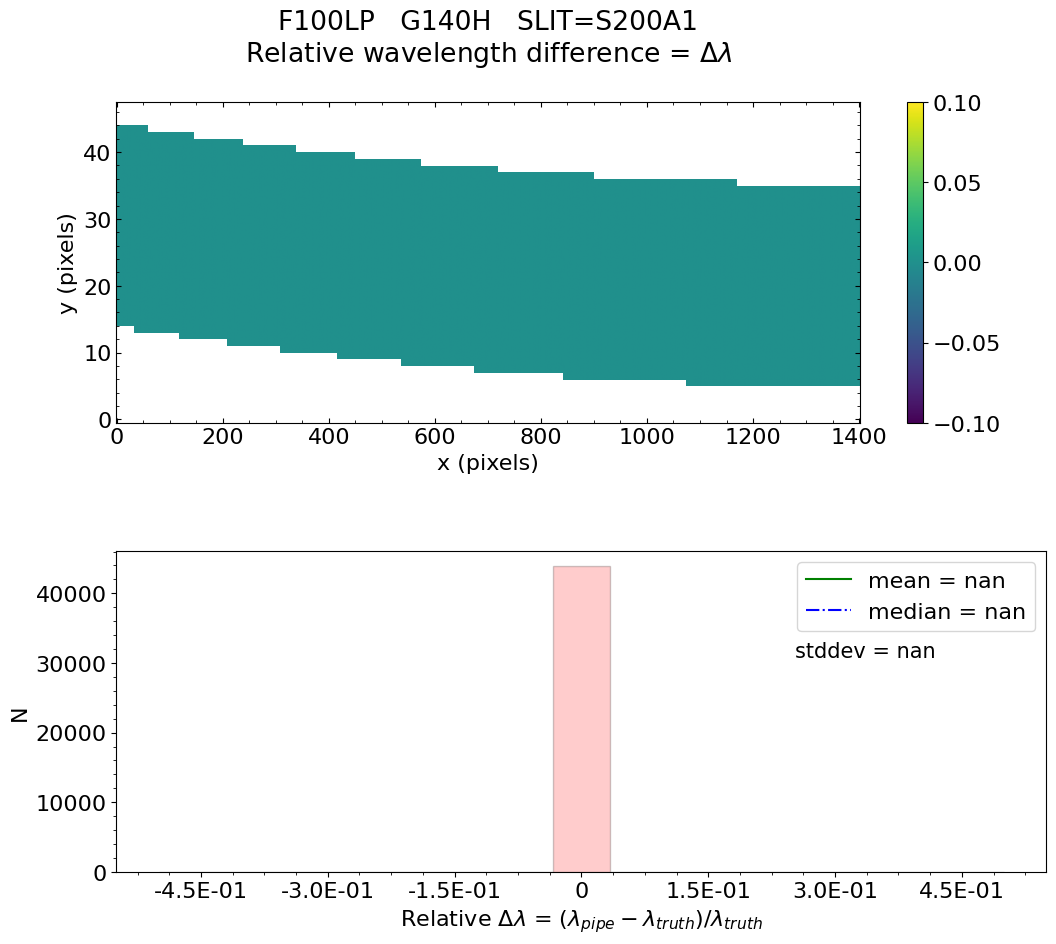

No output_directory was provided. Figures will NOT be saved.


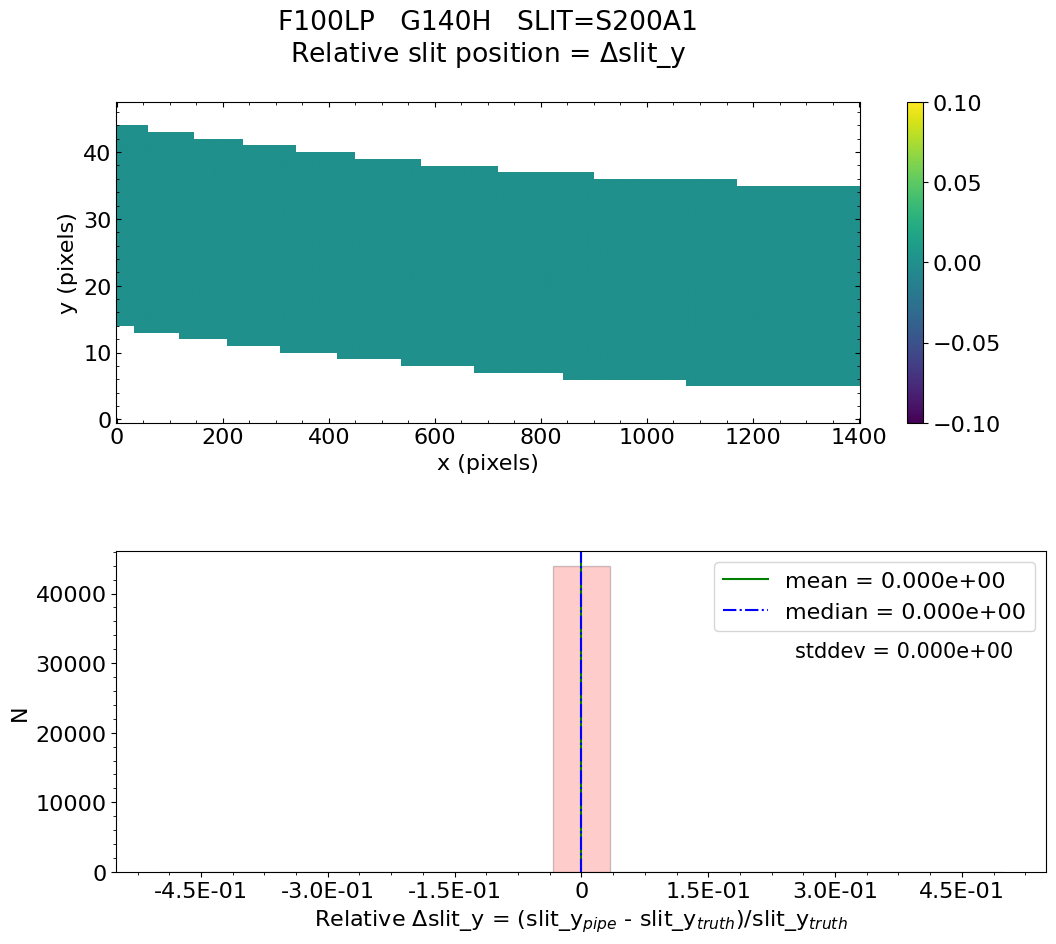

No output_directory was provided. Figures will NOT be saved.


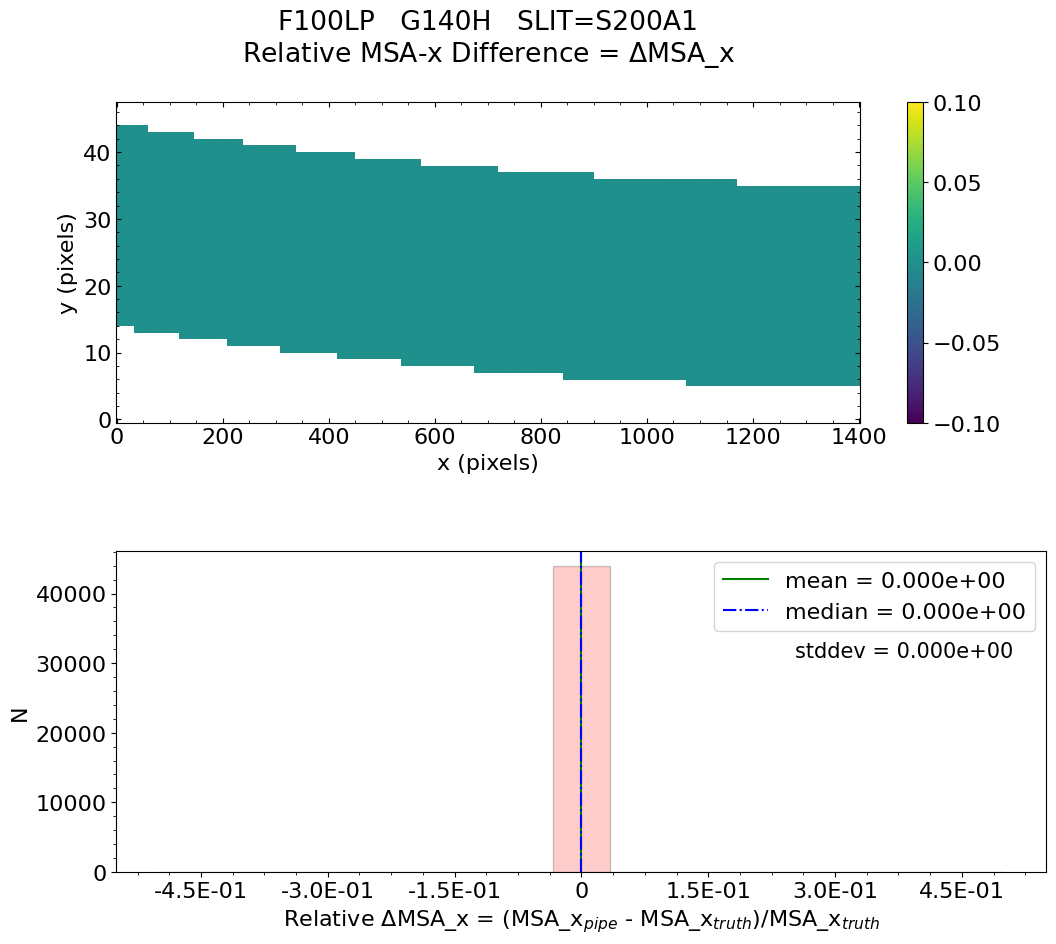

No output_directory was provided. Figures will NOT be saved.


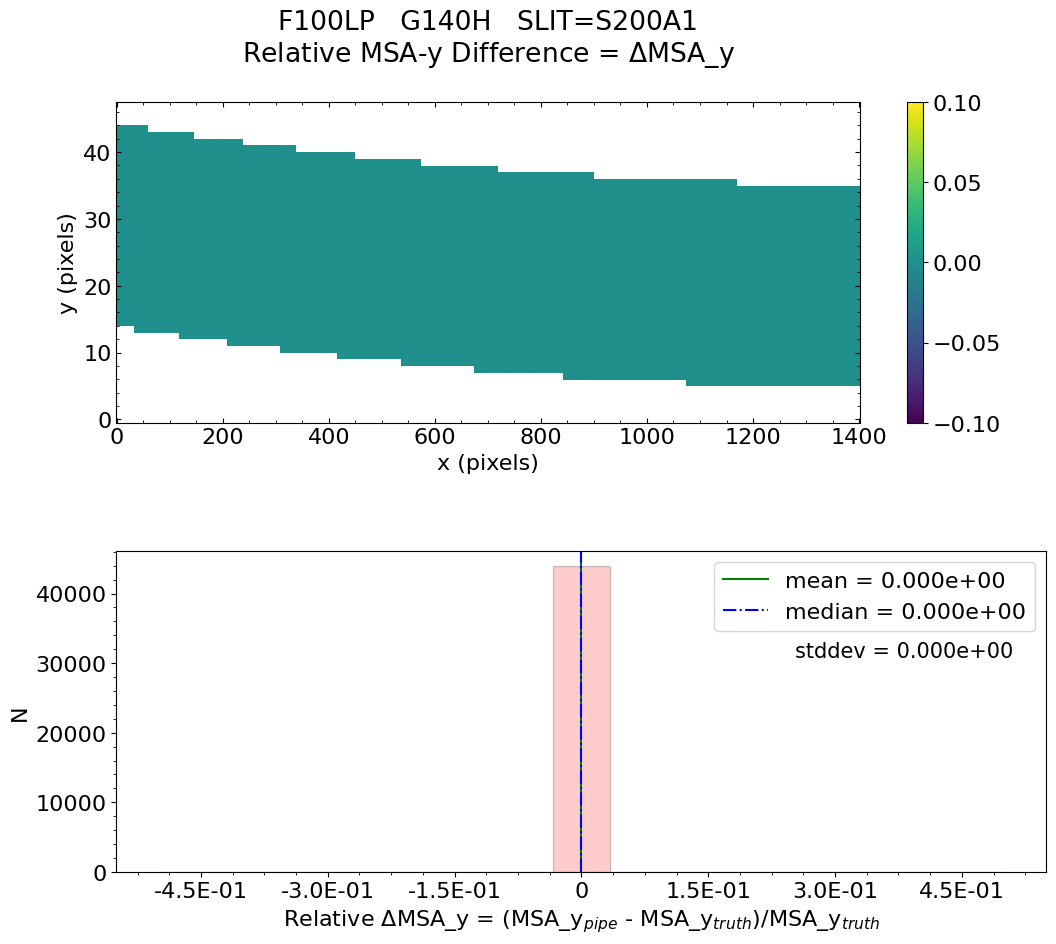

No output_directory was provided. Figures will NOT be saved.


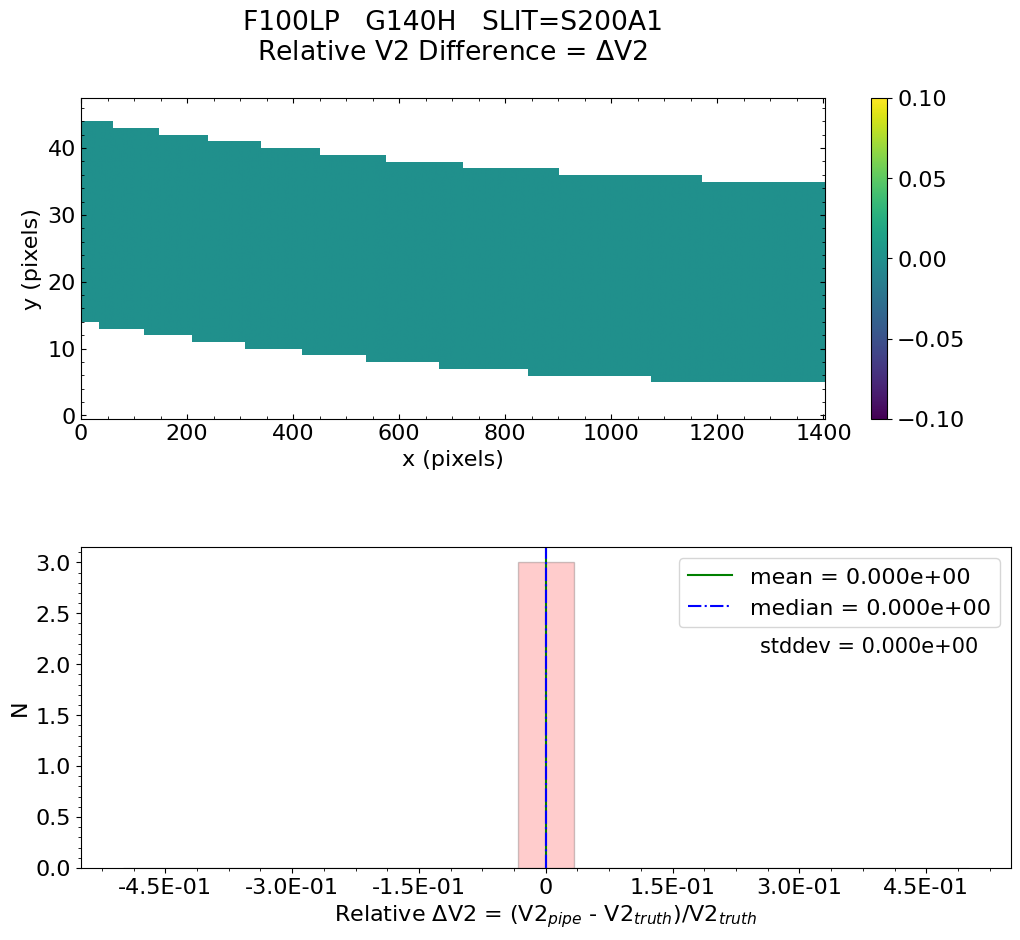

No output_directory was provided. Figures will NOT be saved.


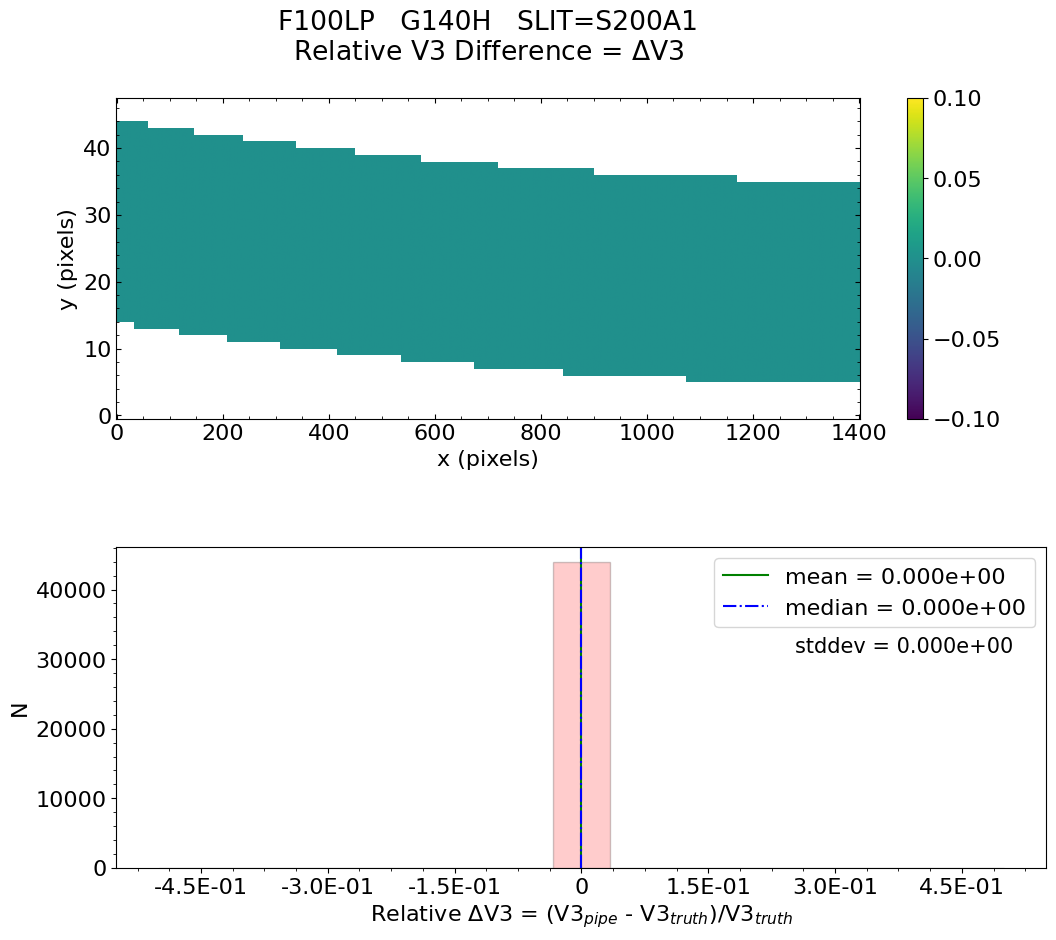


Working with slit: S200A2


Avalable frames:  ['detector', 'sca', 'gwa', 'slit_frame', 'msa_frame', 'oteip', 'v2v3', 'v2v3vacorr', 'world']

   Relative Wavelength Difference  :   mean = nan    median = nan    stdev = nan
    Maximum   RelativeWavelength Difference = nan
    Minimum   RelativeWavelength Difference = nan
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  FAILED


   Relative Slit-Y Difference  :   mean = 2.448e-16    median = 0.000e+00    stdev = 1.381e-14
    Maximum   RelativeSlit-Y Difference = 4.345e-13
    Minimum   RelativeSlit-Y Difference = -1.111e-13
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0

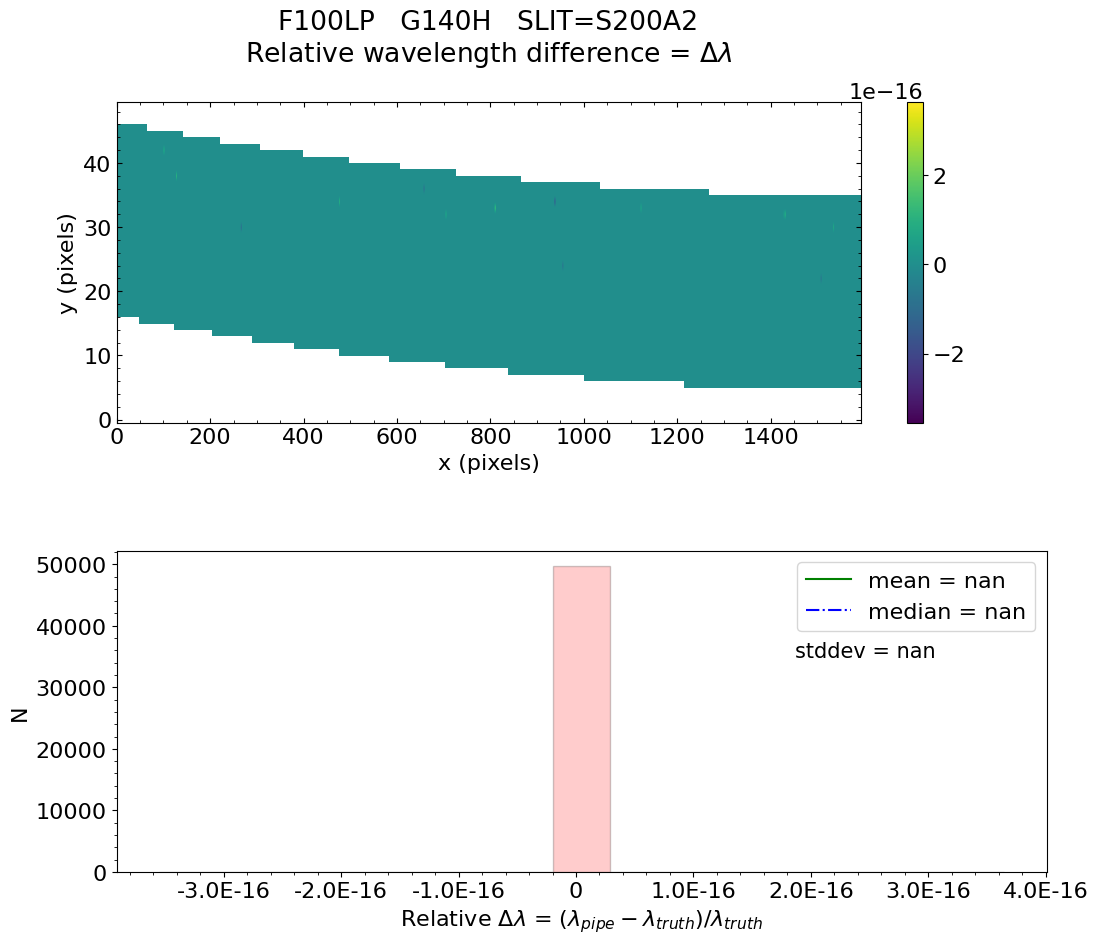

No output_directory was provided. Figures will NOT be saved.


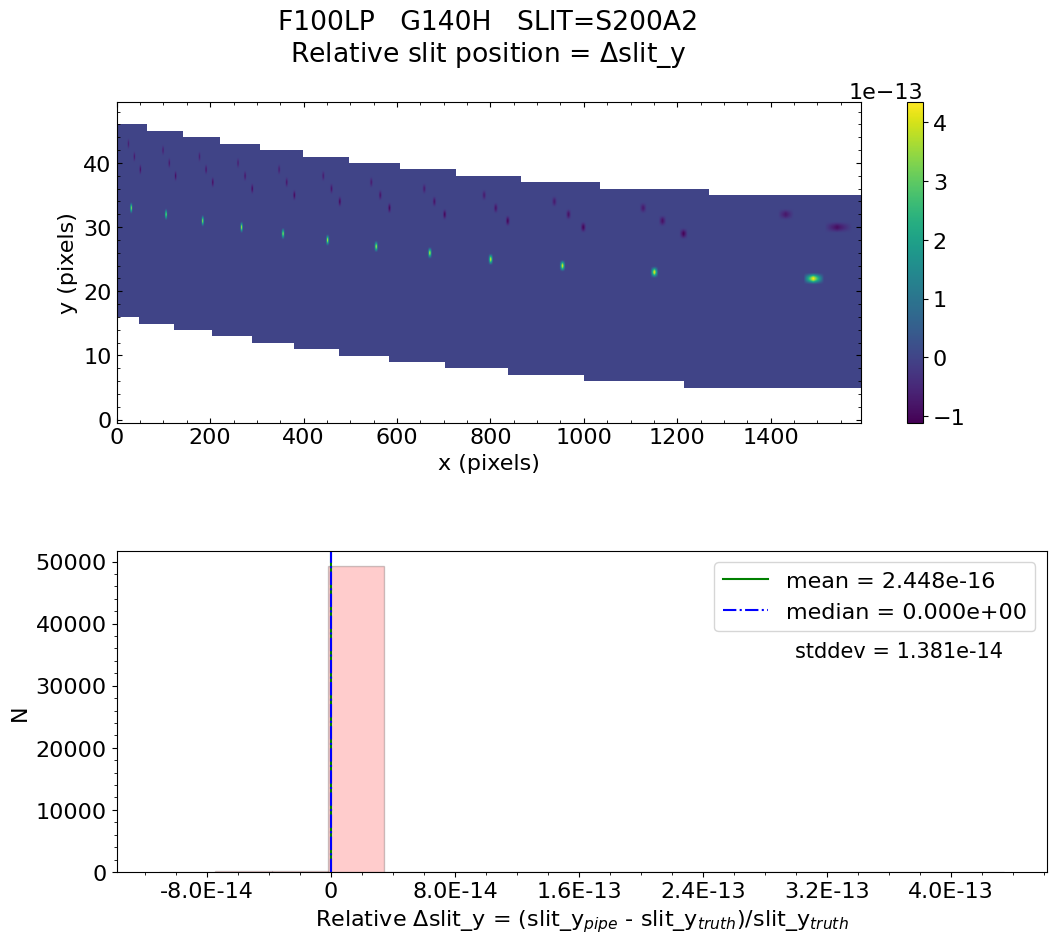

No output_directory was provided. Figures will NOT be saved.


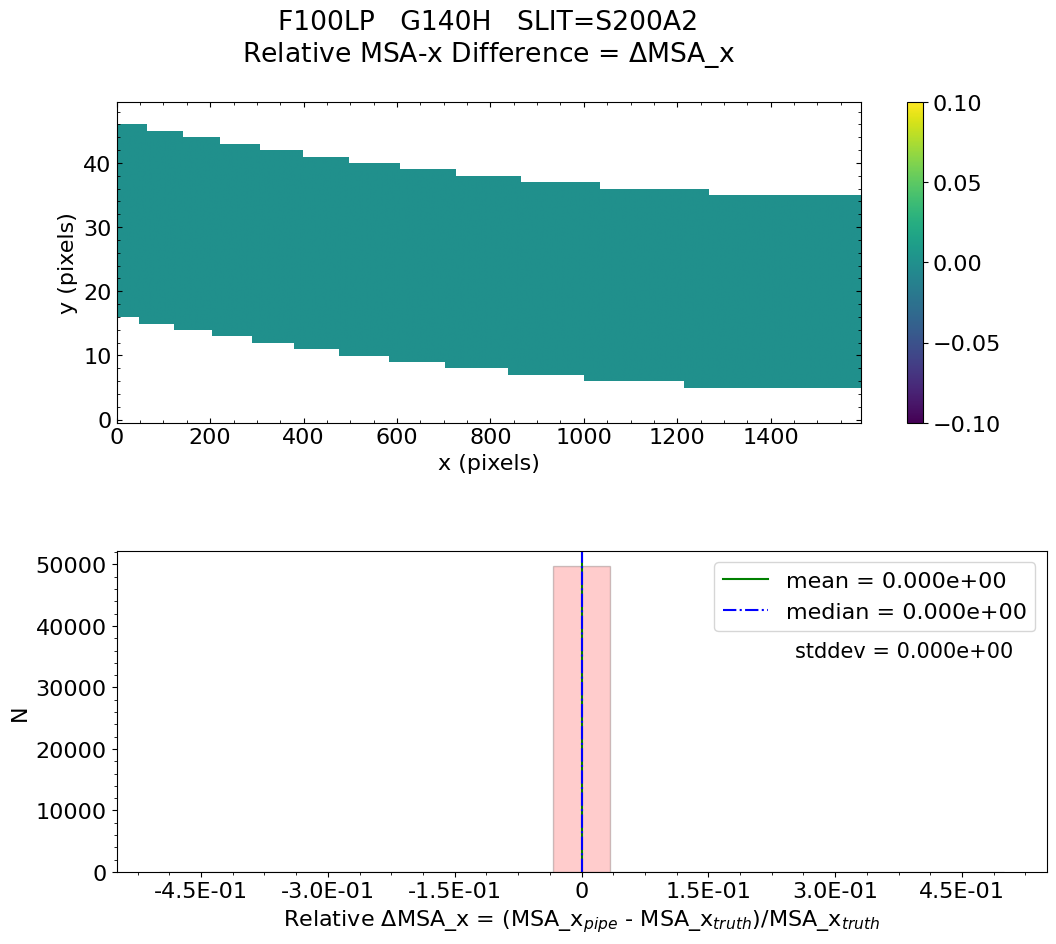

No output_directory was provided. Figures will NOT be saved.


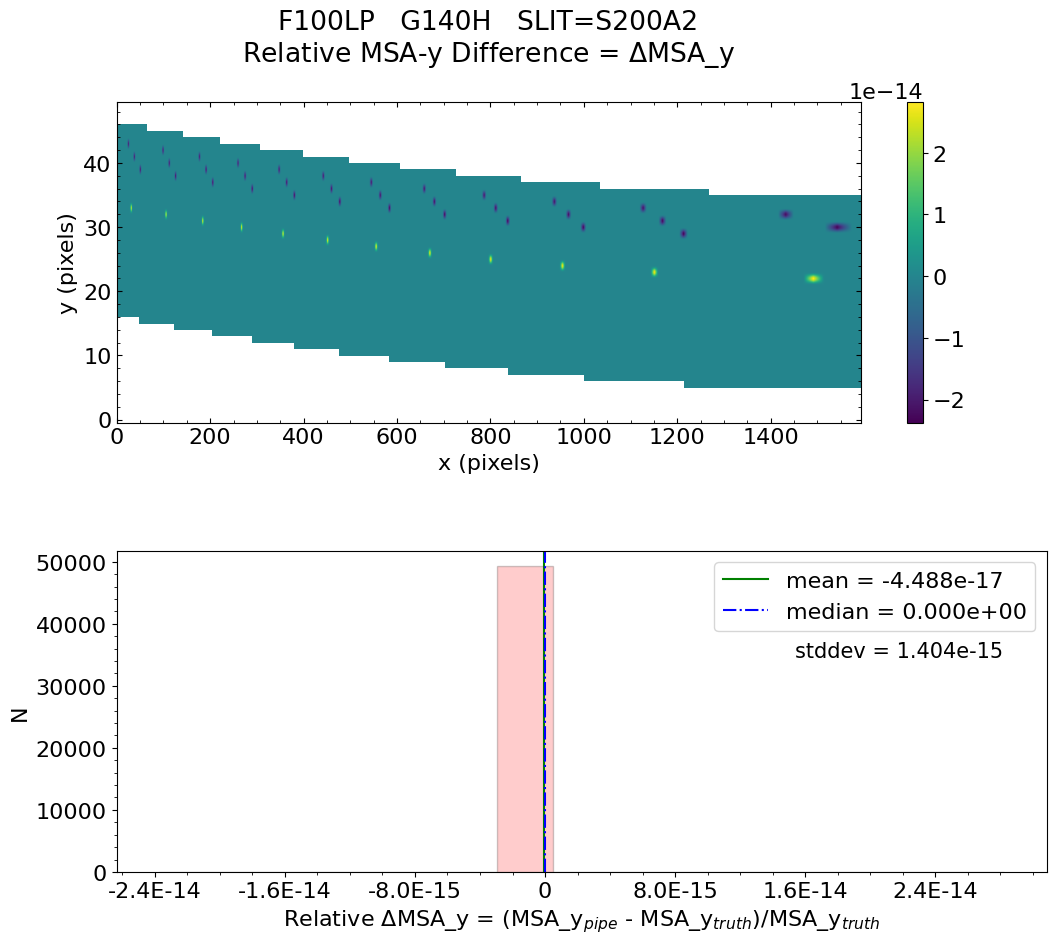

No output_directory was provided. Figures will NOT be saved.


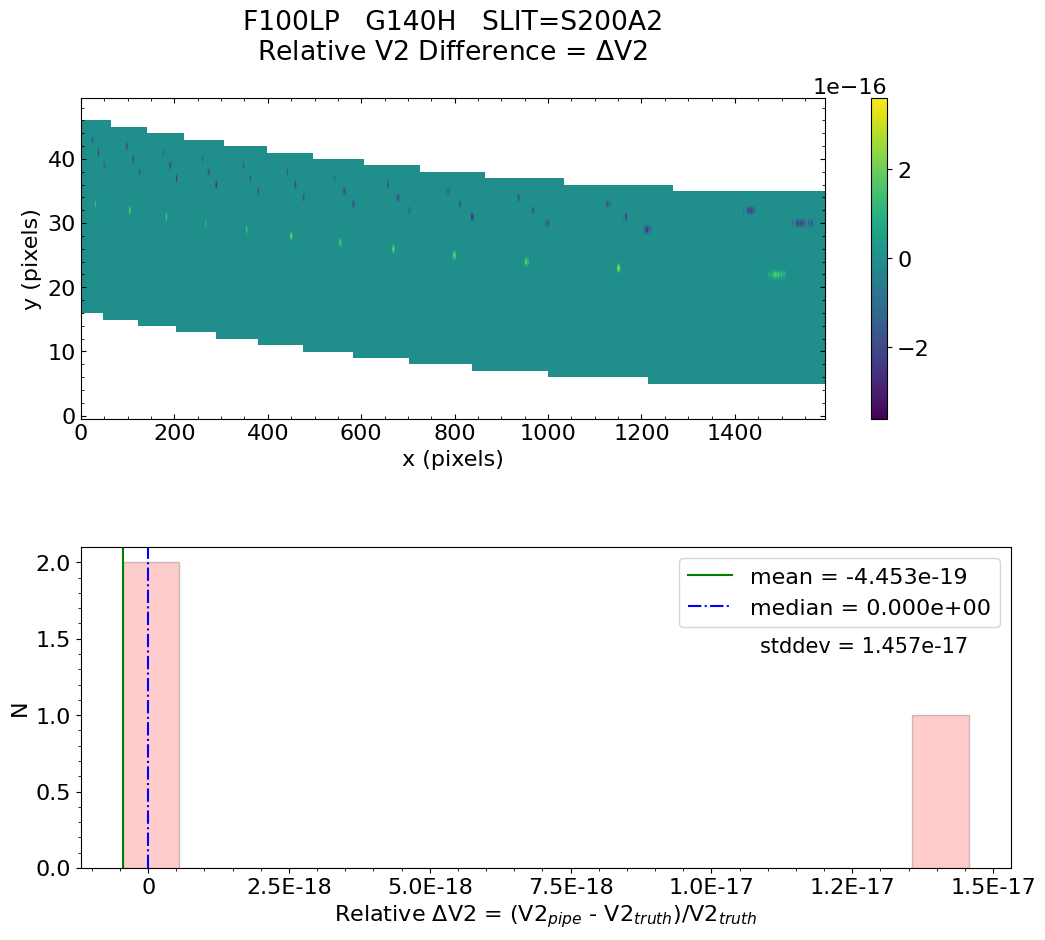

No output_directory was provided. Figures will NOT be saved.


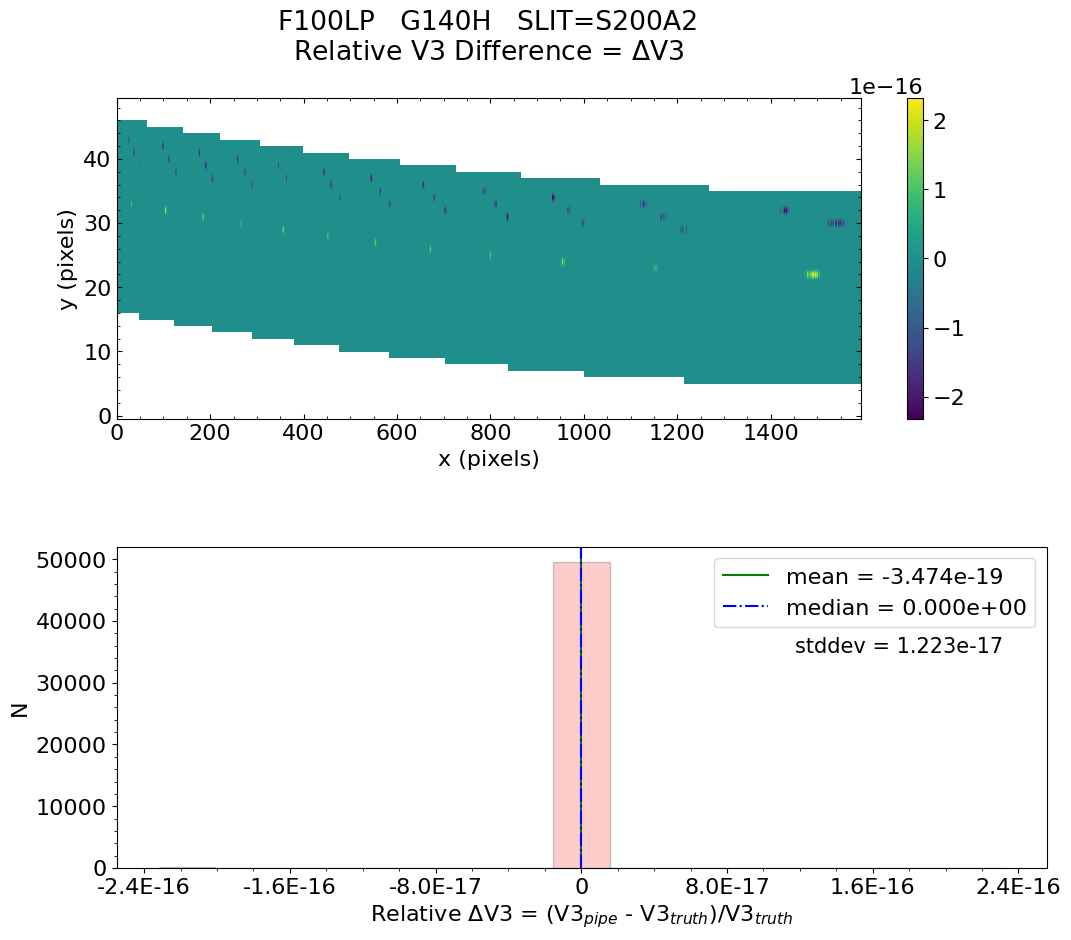


Working with slit: S400A1


Avalable frames:  ['detector', 'sca', 'gwa', 'slit_frame', 'msa_frame', 'oteip', 'v2v3', 'v2v3vacorr', 'world']

   Relative Wavelength Difference  :   mean = nan    median = nan    stdev = nan
    Maximum   RelativeWavelength Difference = nan
    Minimum   RelativeWavelength Difference = nan
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  FAILED


   Relative Slit-Y Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeSlit-Y Difference = -0.000e+00
    Minimum   RelativeSlit-Y Difference = -0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 


   Relative V2 difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeV2 difference = 0.000e+00
    Minimum   RelativeV2 difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for V2 difference:  PASSED


   Relative V3 difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeV3 difference = -0.000e+00
    Minimum   RelativeV3 difference = -0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for V3 difference:  PASSED

No output_directory was provided. Figures will be saved in current worki

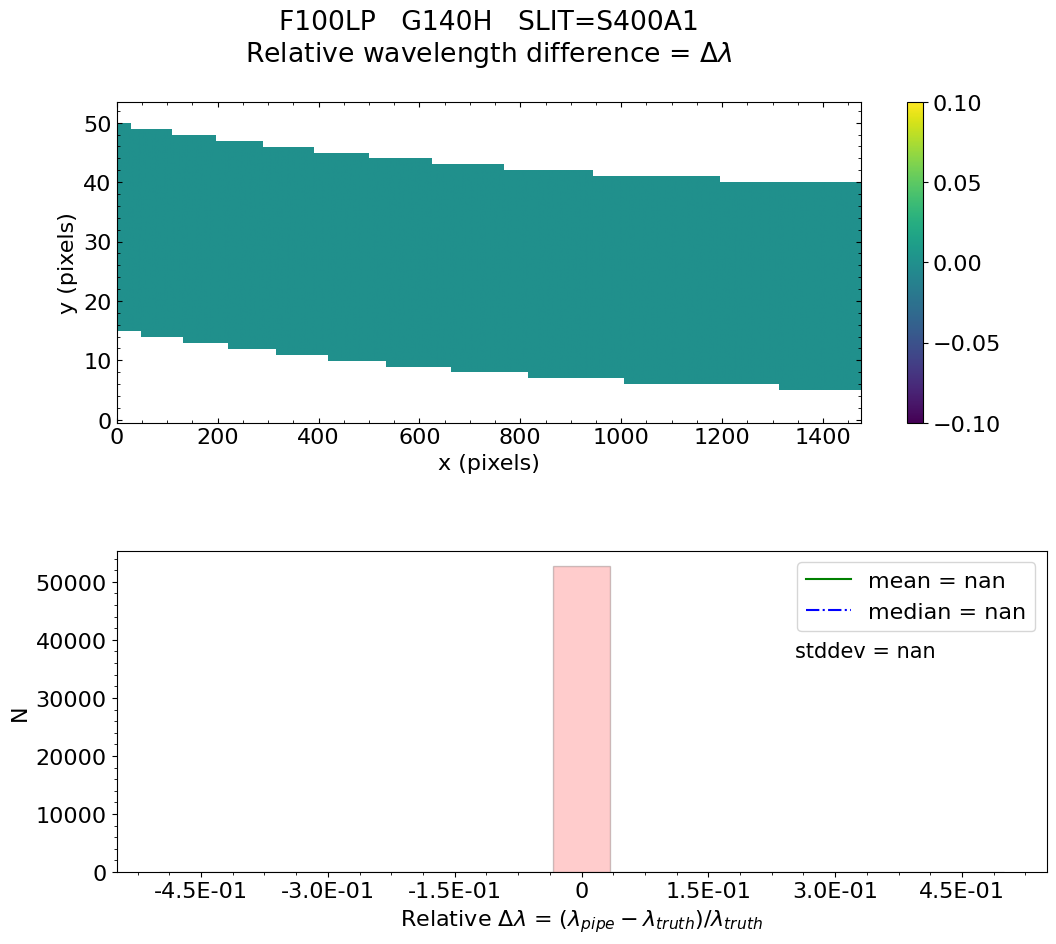

No output_directory was provided. Figures will NOT be saved.


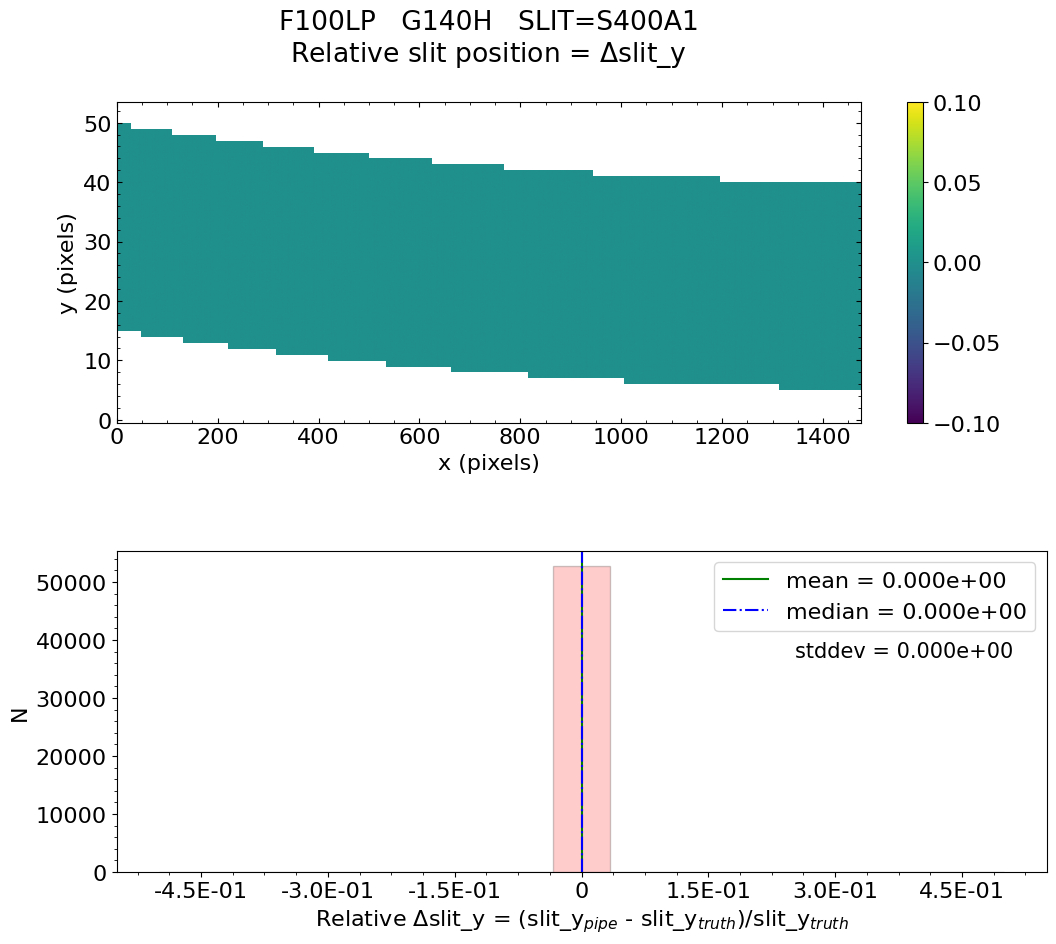

No output_directory was provided. Figures will NOT be saved.


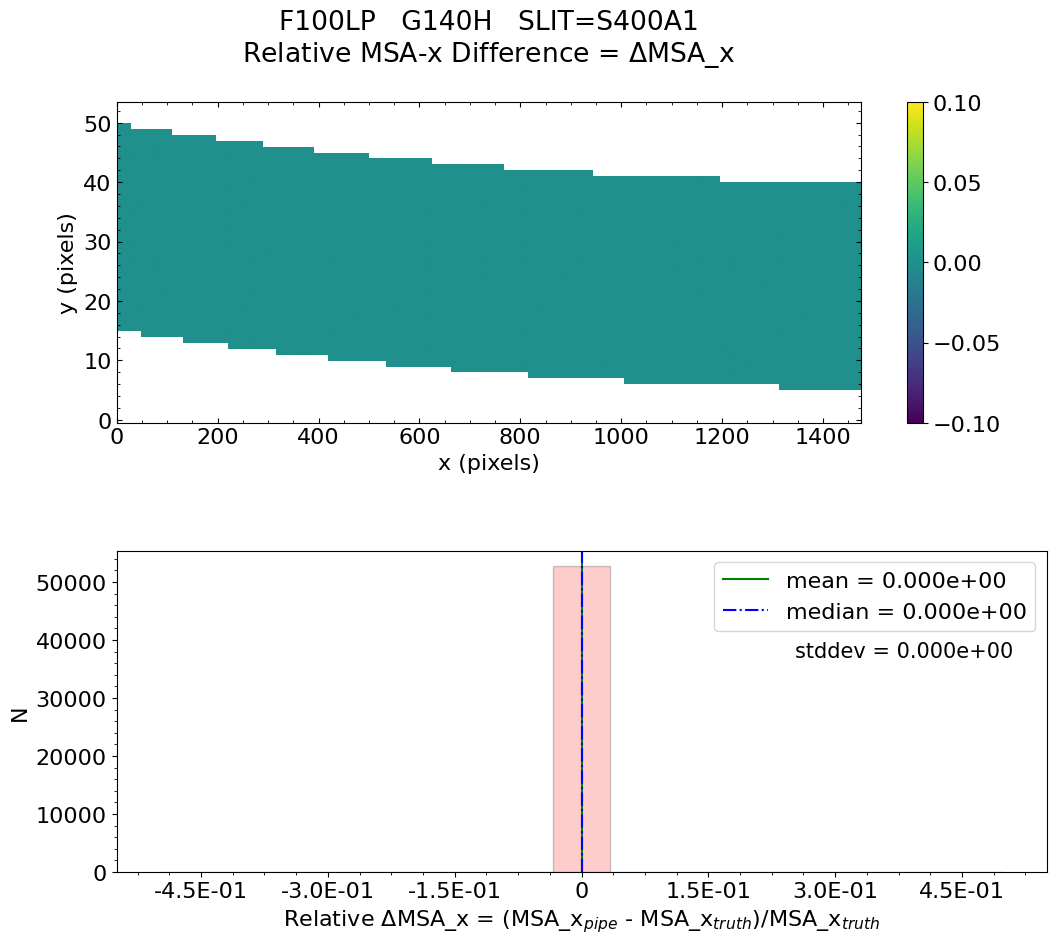

No output_directory was provided. Figures will NOT be saved.


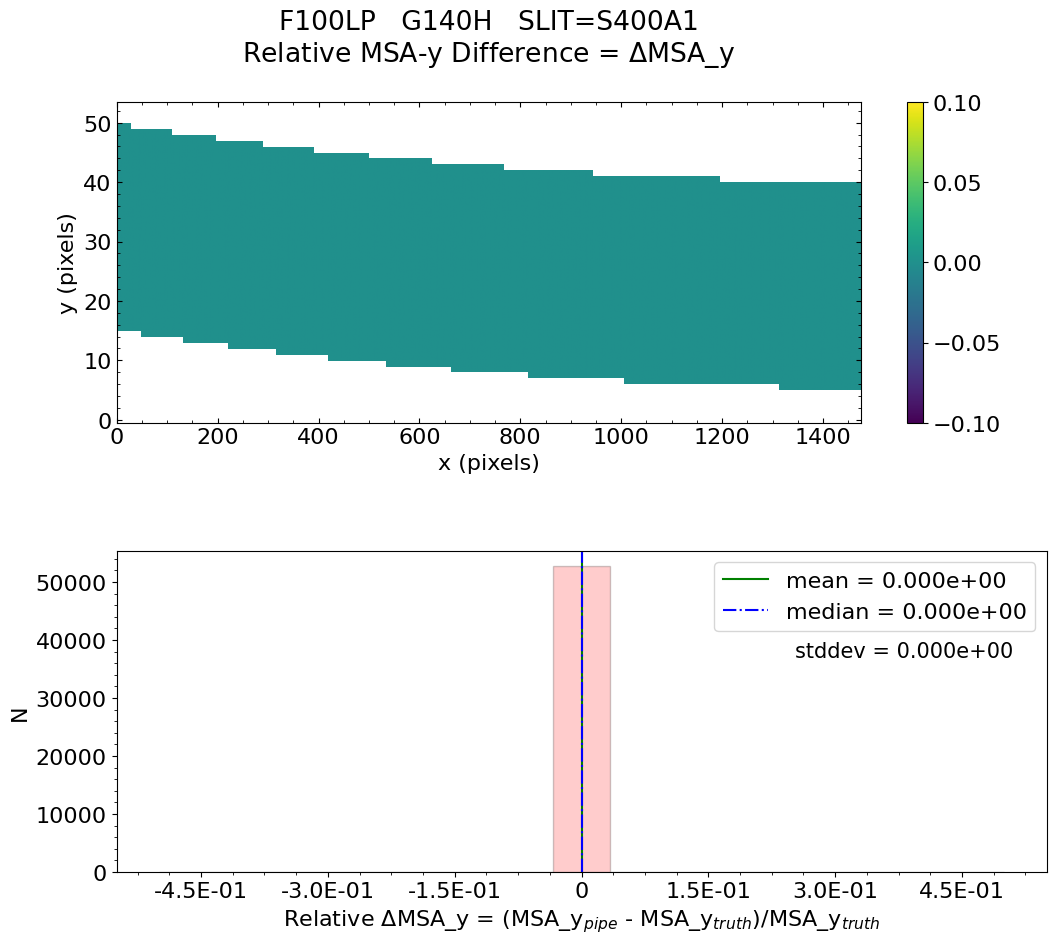

No output_directory was provided. Figures will NOT be saved.


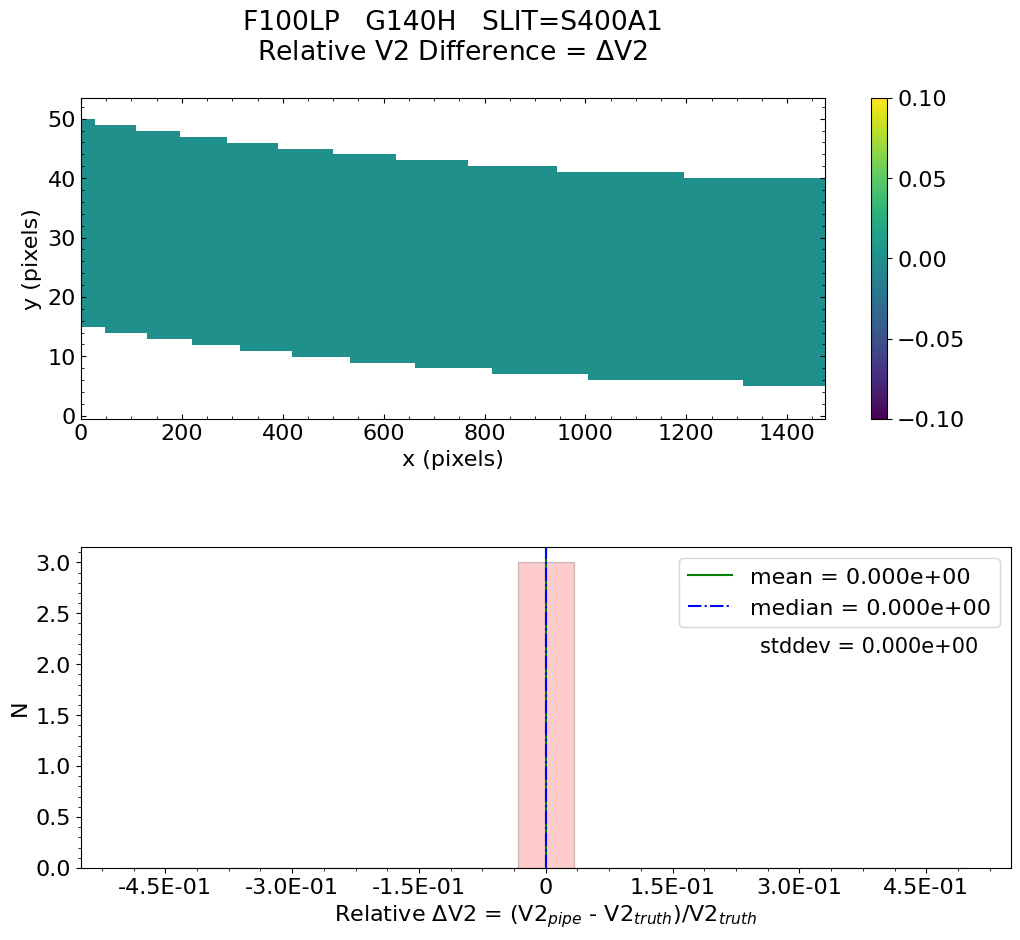

No output_directory was provided. Figures will NOT be saved.


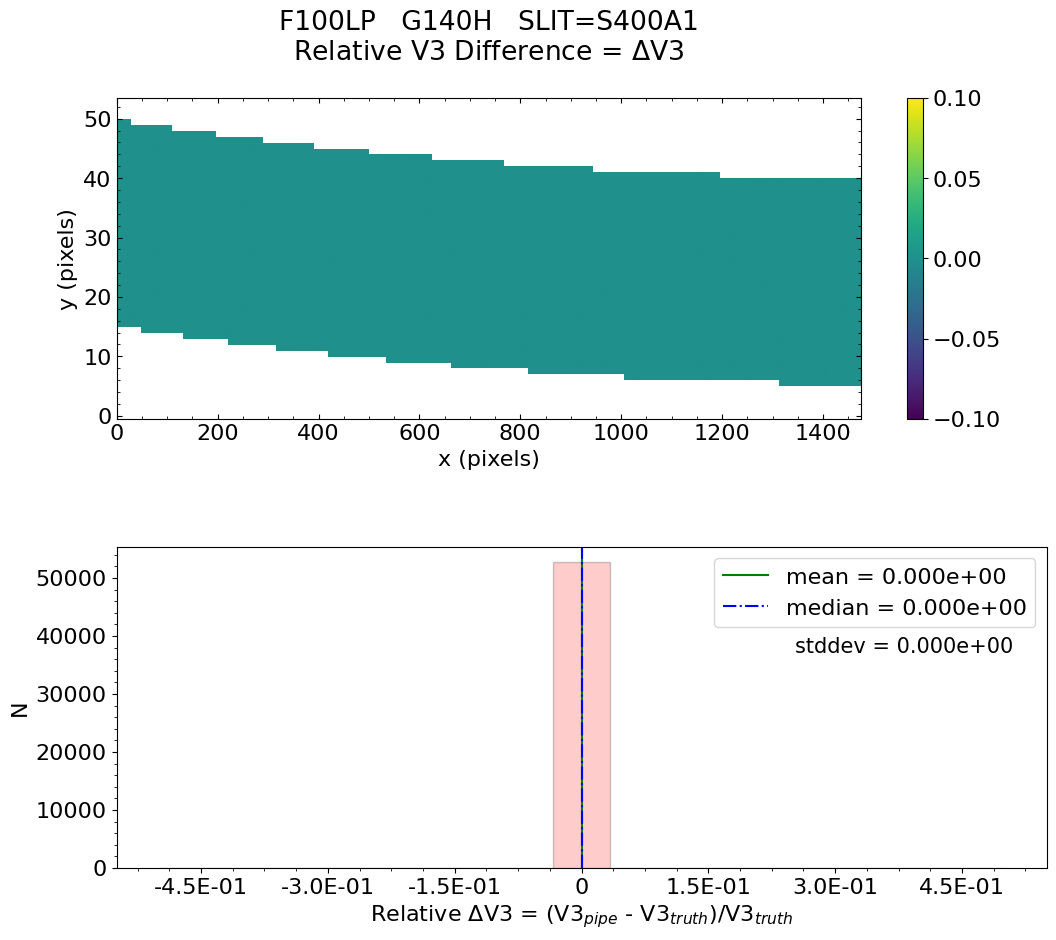


Working with slit: S1600A1


Avalable frames:  ['detector', 'sca', 'gwa', 'slit_frame', 'msa_frame', 'oteip', 'v2v3', 'v2v3vacorr', 'world']

   Relative Wavelength Difference  :   mean = 2.616e-20    median = 0.000e+00    stdev = 2.265e-18
    Maximum   RelativeWavelength Difference = 2.141e-16
    Minimum   RelativeWavelength Difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  PASSED


   Relative Slit-Y Difference  :   mean = -2.030e-16    median = 0.000e+00    stdev = 4.955e-15
    Maximum   RelativeSlit-Y Difference = -0.000e+00
    Minimum   RelativeSlit-Y Difference = -1.810e-13
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
              

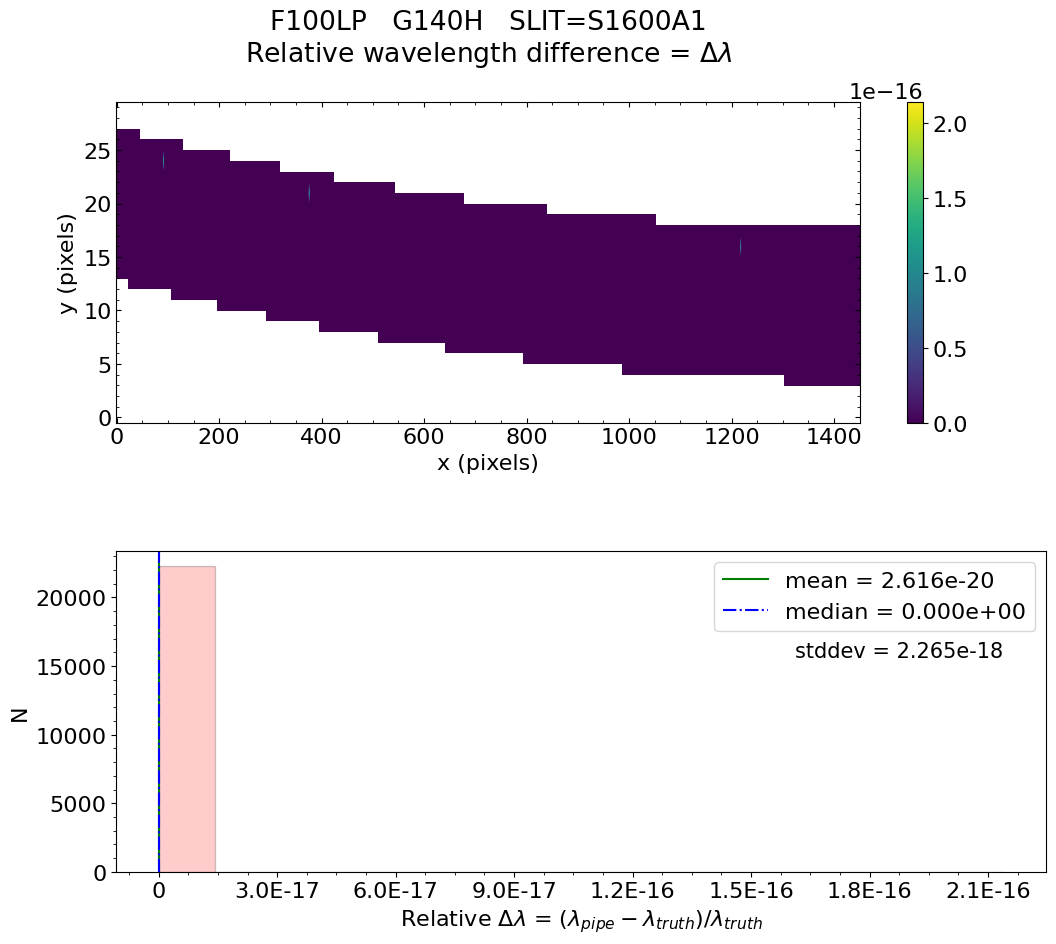

No output_directory was provided. Figures will NOT be saved.


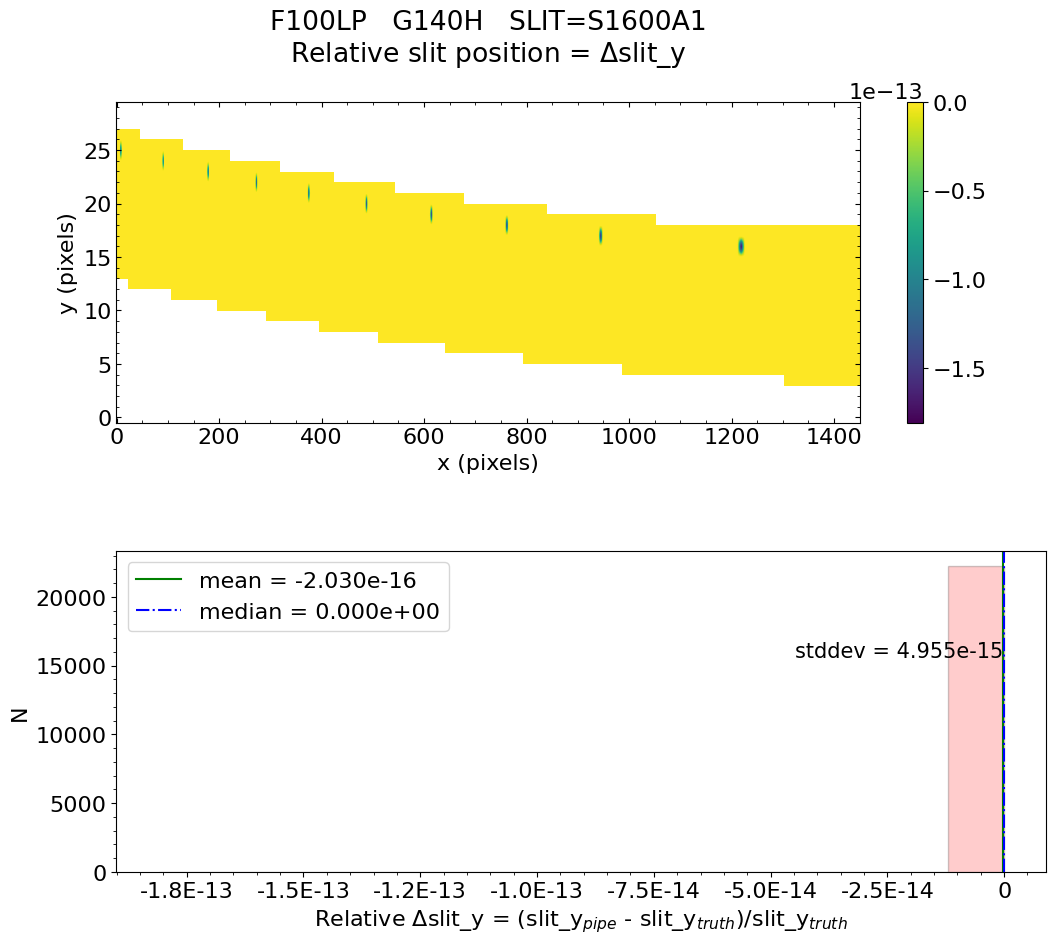

No output_directory was provided. Figures will NOT be saved.


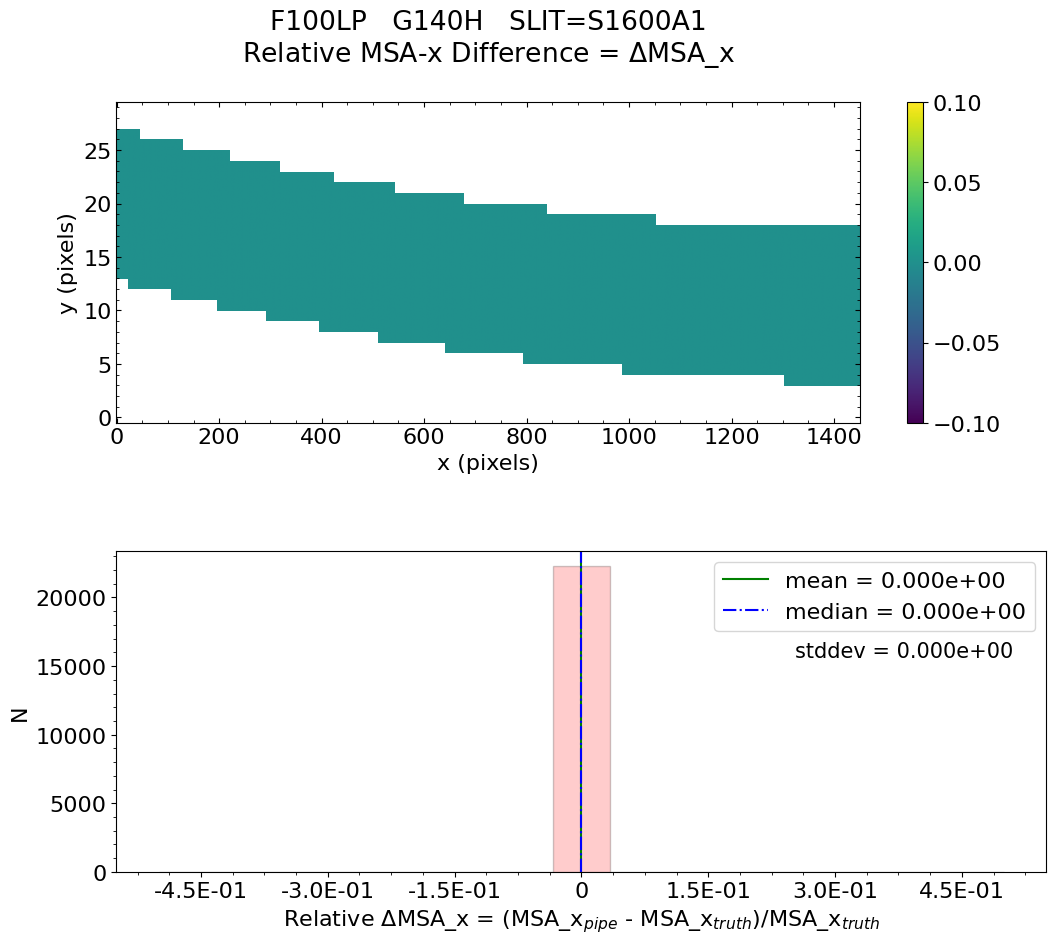

No output_directory was provided. Figures will NOT be saved.


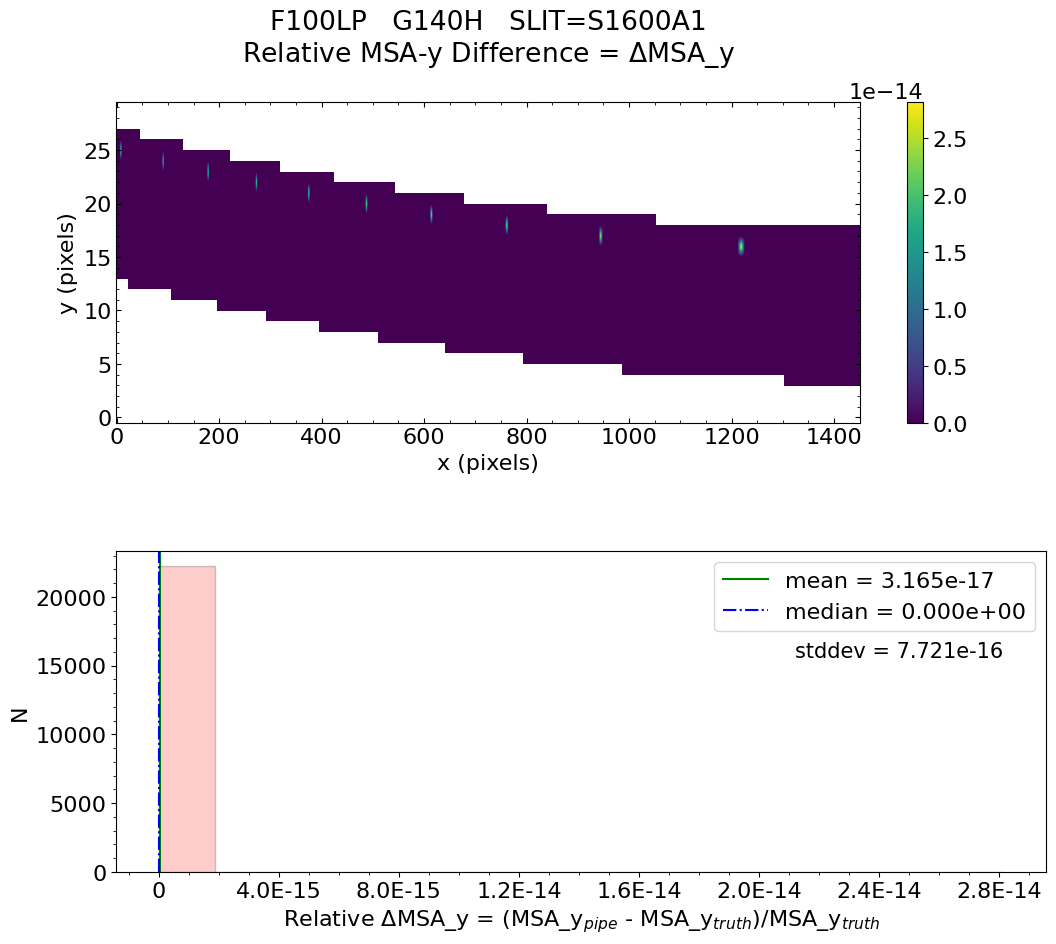

No output_directory was provided. Figures will NOT be saved.


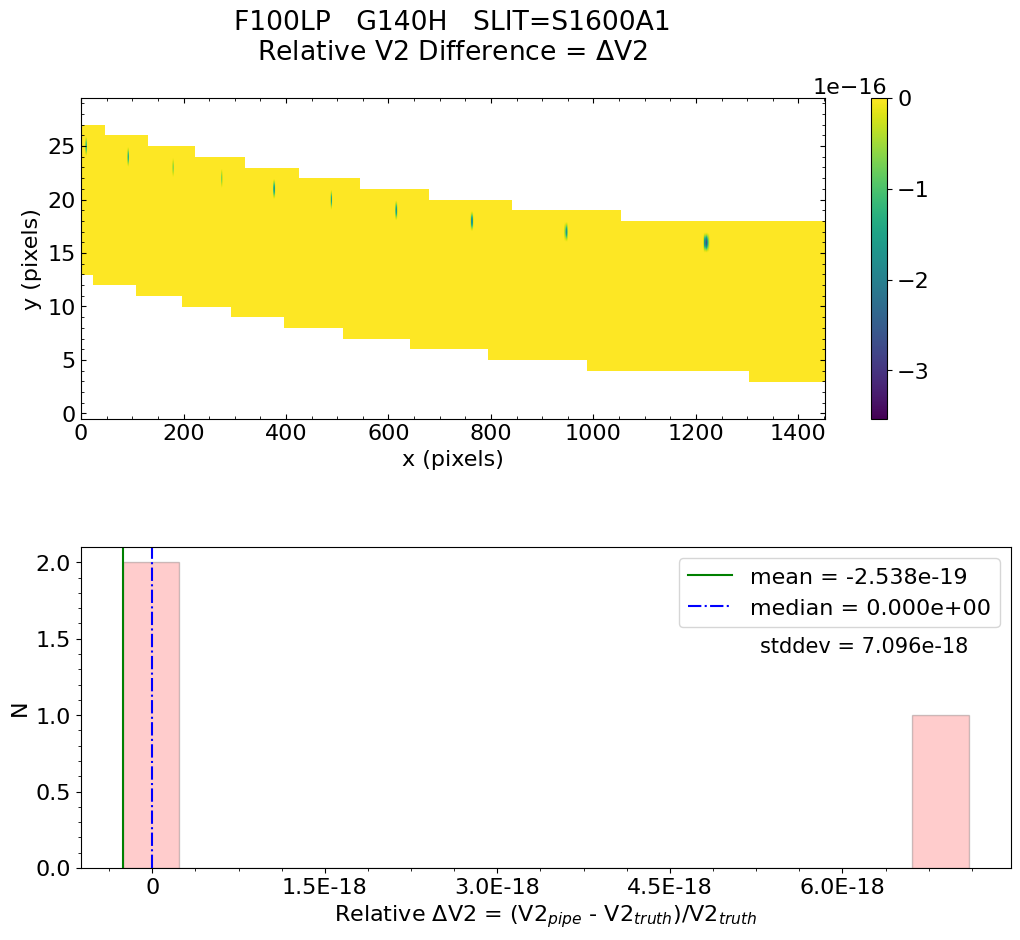

No output_directory was provided. Figures will NOT be saved.


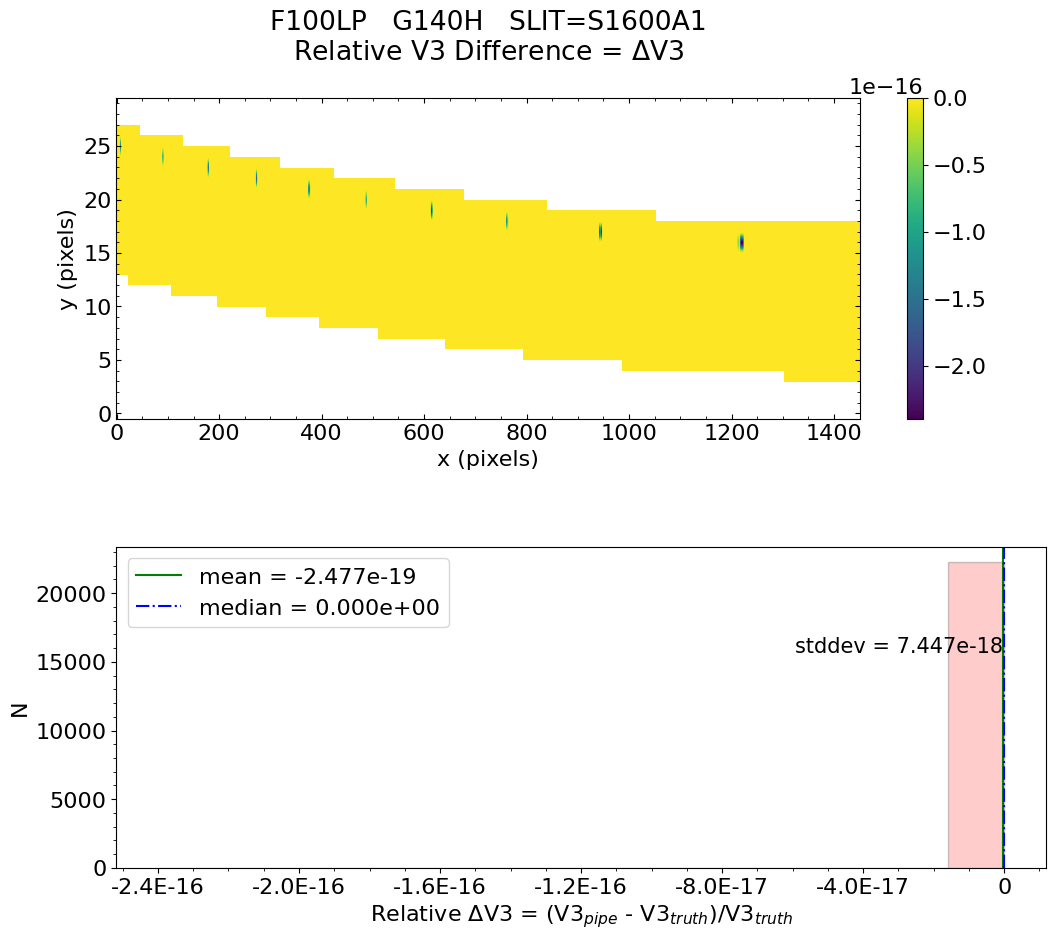


 * The test of V3 difference for slit S200A1 PASSED.

 * The test of V3 difference for slit S200A2 PASSED.

 * The test of V3 difference for slit S400A1 PASSED.

 * The test of V3 difference for slit S1600A1 PASSED.

 *** Final result for assign_wcs test will be reported as PASSED *** 

Did FS ALLSLITS assign_wcs validation test passed?  PASSED 


Testing files for detector:  nrs2


Working with uncal_file:  fs_allslits_g140h_f100lp_nrs2_uncal.fits
Filter =  F100LP
Running detector1 pipeline...


2022-10-03 19:44:09,640 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2022-10-03 19:44:09,671 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-03 19:44:09,673 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-03 19:44:09,674 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-03 19:44:09,675 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-03 19:44:09,676 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-03 19:44:09,677 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-03 19:44:09,678 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-03 19:44:09,679 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-03 19:44:09,680 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-03 19:44:09,681 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-03 19:44:09,682 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-03 19:44:09,683 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-03 19:44:09,684 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-03 19:44:09,686 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-03 19:44:09,688 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-03 19:44:09,689 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-03 19:44:09,690 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-03 19:44:10,158 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt/fs_allslits_g140h_f100lp_nrs2_uncal.fits',).


2022-10-03 19:44:10,169 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-10-03 19:44:10,561 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'fs_allslits_g140h_f100lp_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-03 19:44:10,592 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0128.fits'.


2022-10-03 19:44:10,596 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits'.


2022-10-03 19:44:10,599 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0009.fits'.


2022-10-03 19:44:10,602 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0025.fits'.


2022-10-03 19:44:10,605 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-03 19:44:10,606 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0007.fits'.


2022-10-03 19:44:10,608 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-10-03 19:44:10,608 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-03 19:44:10,608 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-10-03 19:44:10,609 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0011.fits'.


2022-10-03 19:44:10,611 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0148.fits'.


2022-10-03 19:44:10,613 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-03 19:44:10,613 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-03 19:44:10,614 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-03 19:44:11,656 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 19:44:11,658 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 19:44:12,150 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-10-03 19:44:12,151 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-03 19:44:12,155 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-03 19:44:12,449 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 19:44:12,451 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 19:44:12,478 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0025.fits


2022-10-03 19:44:13,575 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-10-03 19:44:13,595 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-03 19:44:13,877 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 19:44:13,879 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt', 'n_pix_grow_sat': 1}


2022-10-03 19:44:13,905 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0011.fits


2022-10-03 19:44:15,086 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-10-03 19:44:20,148 - stpipe.Detector1Pipeline.saturation - INFO - Detected 3880 saturated pixels


2022-10-03 19:44:20,224 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-03 19:44:20,233 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-03 19:44:20,499 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 19:44:20,500 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 19:44:20,501 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-03 19:44:20,504 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-03 19:44:20,644 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 19:44:20,645 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 19:44:20,671 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0148.fits


2022-10-03 19:44:21,483 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-10-03 19:44:21,608 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 19:44:21,609 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-03 19:44:22,086 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2022-10-03 19:44:22,091 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2022-10-03 19:44:22,092 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-10-03 19:44:22,092 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-10-03 19:44:22,092 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-10-03 19:44:22,093 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-10-03 19:44:22,093 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-10-03 19:44:22,094 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-10-03 19:44:22,094 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False


2022-10-03 19:44:22,126 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-03 19:44:22,251 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 19:44:22,253 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 19:44:22,275 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0009.fits


2022-10-03 19:44:26,566 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-03 19:44:26,696 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 19:44:26,697 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt', 'dark_output': None}


2022-10-03 19:44:26,722 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0128.fits


2022-10-03 19:44:28,411 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=25, ngroups=10, nframes=1, groupgap=0


2022-10-03 19:44:28,411 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0


2022-10-03 19:44:29,490 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-03 19:44:29,612 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 19:44:29,614 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-03 19:44:29,623 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-03 19:44:29,639 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-10-03 19:44:30,796 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0007.fits


2022-10-03 19:44:31,953 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-10-03 19:44:31,954 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-10-03 19:44:32,196 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-03 19:44:32,445 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-10-03 19:44:32,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518131 pixels with at least one CR from five or more groups.


2022-10-03 19:44:32,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42 pixels with at least one CR from four groups.


2022-10-03 19:44:32,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 64 pixels with at least one CR from three groups.


2022-10-03 19:47:20,537 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-03 19:47:20,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 196101 pixels with at least one CR from five or more groups.


2022-10-03 19:47:20,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 19:47:20,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 19:47:48,950 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-03 19:47:49,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 146921 pixels with at least one CR from five or more groups.


2022-10-03 19:47:49,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-03 19:47:49,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:48:08,581 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-03 19:48:08,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 345476 pixels with at least one CR from five or more groups.


2022-10-03 19:48:08,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-03 19:48:08,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:49:01,563 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 5:


2022-10-03 19:49:01,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 366824 pixels with at least one CR from five or more groups.


2022-10-03 19:49:01,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8 pixels with at least one CR from four groups.


2022-10-03 19:49:01,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31 pixels with at least one CR from three groups.


2022-10-03 19:49:53,385 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 6:


2022-10-03 19:49:53,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 461130 pixels with at least one CR from five or more groups.


2022-10-03 19:49:53,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5 pixels with at least one CR from four groups.


2022-10-03 19:49:53,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16 pixels with at least one CR from three groups.


2022-10-03 19:51:16,677 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 7:


2022-10-03 19:51:17,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518156 pixels with at least one CR from five or more groups.


2022-10-03 19:51:17,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17 pixels with at least one CR from four groups.


2022-10-03 19:51:17,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10 pixels with at least one CR from three groups.


2022-10-03 19:54:08,937 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 8:


2022-10-03 19:54:09,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508361 pixels with at least one CR from five or more groups.


2022-10-03 19:54:09,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 19:54:09,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 19:55:21,664 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 9:


2022-10-03 19:55:22,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 427076 pixels with at least one CR from five or more groups.


2022-10-03 19:55:22,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 19:55:22,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:56:33,224 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:


2022-10-03 19:56:33,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 198020 pixels with at least one CR from five or more groups.


2022-10-03 19:56:33,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 19:56:33,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11 pixels with at least one CR from three groups.


2022-10-03 19:57:04,223 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 11:


2022-10-03 19:57:04,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 459455 pixels with at least one CR from five or more groups.


2022-10-03 19:57:04,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-03 19:57:04,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 19:58:28,967 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 12:


2022-10-03 19:58:29,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15640 pixels with at least one CR from five or more groups.


2022-10-03 19:58:29,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 19:58:29,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 19:58:31,839 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 13:


2022-10-03 19:58:32,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 417914 pixels with at least one CR from five or more groups.


2022-10-03 19:58:32,200 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-03 19:58:32,200 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 19:59:29,417 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 14:


2022-10-03 19:59:29,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 477790 pixels with at least one CR from five or more groups.


2022-10-03 19:59:29,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 19:59:29,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3 pixels with at least one CR from three groups.


2022-10-03 20:00:35,924 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 15:


2022-10-03 20:00:36,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40812 pixels with at least one CR from five or more groups.


2022-10-03 20:00:36,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 20:00:36,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 20:00:42,475 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 16:


2022-10-03 20:00:42,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17036 pixels with at least one CR from five or more groups.


2022-10-03 20:00:42,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from four groups.


2022-10-03 20:00:42,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 20:00:45,527 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 17:


2022-10-03 20:00:45,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 146717 pixels with at least one CR from five or more groups.


2022-10-03 20:00:45,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 20:00:45,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 20:01:07,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 18:


2022-10-03 20:01:07,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 132001 pixels with at least one CR from five or more groups.


2022-10-03 20:01:07,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 20:01:07,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 20:01:28,122 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 19:


2022-10-03 20:01:28,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 155724 pixels with at least one CR from five or more groups.


2022-10-03 20:01:28,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-03 20:01:28,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 20:01:54,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 20:


2022-10-03 20:01:54,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52786 pixels with at least one CR from five or more groups.


2022-10-03 20:01:54,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2 pixels with at least one CR from four groups.


2022-10-03 20:01:54,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3 pixels with at least one CR from three groups.


2022-10-03 20:02:02,678 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 21:


2022-10-03 20:02:03,060 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 112405 pixels with at least one CR from five or more groups.


2022-10-03 20:02:03,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3 pixels with at least one CR from four groups.


2022-10-03 20:02:03,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 20:02:20,089 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 22:


2022-10-03 20:02:20,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 171341 pixels with at least one CR from five or more groups.


2022-10-03 20:02:20,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 20:02:20,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-03 20:02:43,585 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 23:


2022-10-03 20:02:43,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 441255 pixels with at least one CR from five or more groups.


2022-10-03 20:02:43,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37 pixels with at least one CR from four groups.


2022-10-03 20:02:43,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42 pixels with at least one CR from three groups.


2022-10-03 20:03:57,308 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 24:


2022-10-03 20:03:57,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 114608 pixels with at least one CR from five or more groups.


2022-10-03 20:03:57,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 20:03:57,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6 pixels with at least one CR from three groups.


2022-10-03 20:04:14,471 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 25:


2022-10-03 20:04:14,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 359800 pixels with at least one CR from five or more groups.


2022-10-03 20:04:14,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.


2022-10-03 20:04:14,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.


2022-10-03 20:05:07,299 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 1235.1 sec


2022-10-03 20:05:07,304 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 1237.680706


2022-10-03 20:05:07,310 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-03 20:05:07,468 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 20:05:07,470 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-03 20:05:07,567 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0007.fits


2022-10-03 20:05:07,568 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-10-03 20:05:10,617 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-10-03 20:05:10,618 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-10-03 20:05:10,619 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-03 20:05:10,619 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-10-03 20:08:33,039 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2022-10-03 20:08:33,040 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 25


2022-10-03 20:08:33,143 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-03 20:08:33,290 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 20:08:33,292 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 20:08:33,370 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-03 20:08:33,371 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-03 20:08:33,375 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-03 20:08:33,490 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(25, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 20:08:33,492 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt'}


2022-10-03 20:08:33,564 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-03 20:08:33,564 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-03 20:08:33,568 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-03 20:08:33,569 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-03 20:08:33,569 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-03 20:08:33,570 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-03 20:08:33,578 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-03 20:08:33,694 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).


2022-10-03 20:08:33,695 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


Running spec2 pipeline...


2022-10-03 20:08:33,908 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1343955546617508 deg


2022-10-03 20:08:33,909 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3604099452495575 deg


2022-10-03 20:08:33,909 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0019762940493390285 deg


2022-10-03 20:08:33,910 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-03 20:08:34,186 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS2: ['S200A1', 'S200A2', 'S400A1', 'S1600A1', 'S200B1']


2022-10-03 20:08:34,187 - stpipe.AssignWcsStep - INFO - Computing WCS for 5 open slitlets


2022-10-03 20:08:34,221 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1343955546617508 deg


2022-10-03 20:08:34,222 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3604099452495575 deg


2022-10-03 20:08:34,222 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0019762940493390285 deg


2022-10-03 20:08:34,223 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-03 20:08:34,236 - stpipe.AssignWcsStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]


2022-10-03 20:08:34,380 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 1


2022-10-03 20:08:34,380 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 2


2022-10-03 20:08:34,381 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 3


2022-10-03 20:08:34,381 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 4


2022-10-03 20:08:34,381 - stpipe.AssignWcsStep - INFO - There are 5 open slits in quadrant 5


2022-10-03 20:08:34,566 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_fixedslit pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0033.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0023.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-03 20:08:34,772 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-10-03 20:08:34,785 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-03 20:08:34,786 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Running test for FS...
Information from the 'truth' (or comparison) file 
Filename: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmbualfdt/fs_allslits_g140h_f100lp_nrs2_assign_wcs_truth.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     264   ()      
  1  SCI           1 ImageHDU        50   (2048, 256)   float32   
  2  ERR           1 ImageHDU        10   (2048, 256)   float32   
  3  DQ            1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (2048, 256)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (2048, 256)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [221053B]   


None


Comparing to ST 'truth' file.
from assign_wcs file  -->     Detector: NRS2   Grating: G140H   Filter: F100LP   Lamp: NO_LAMP
GWA_XTILT: 0.3604099452495575
GWA_YTILT: 0.1343955546617508
GWA_TTILT: 37.0910277792677

Working with slit: S200A1


Avalable frames:  ['detector', 'sca', 'gwa', 'slit_frame', 'msa_frame', 'oteip', 'v2v3', 'v2v3vacorr', 'world']

   Relative Wavelength Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeWavelength Difference = 0.000e+00
    Minimum   RelativeWavelength Difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  PASSED


   Relative Slit-Y Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeSlit-Y Difference = -0.000e+00
    Minimum   RelativeSlit-Y Difference = -0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
               


   Relative V2 difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeV2 difference = 0.000e+00
    Minimum   RelativeV2 difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for V2 difference:  PASSED


   Relative V3 difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeV3 difference = -0.000e+00
    Minimum   RelativeV3 difference = -0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for V3 difference:  PASSED

No output_directory was provided. Figures will be saved in current worki

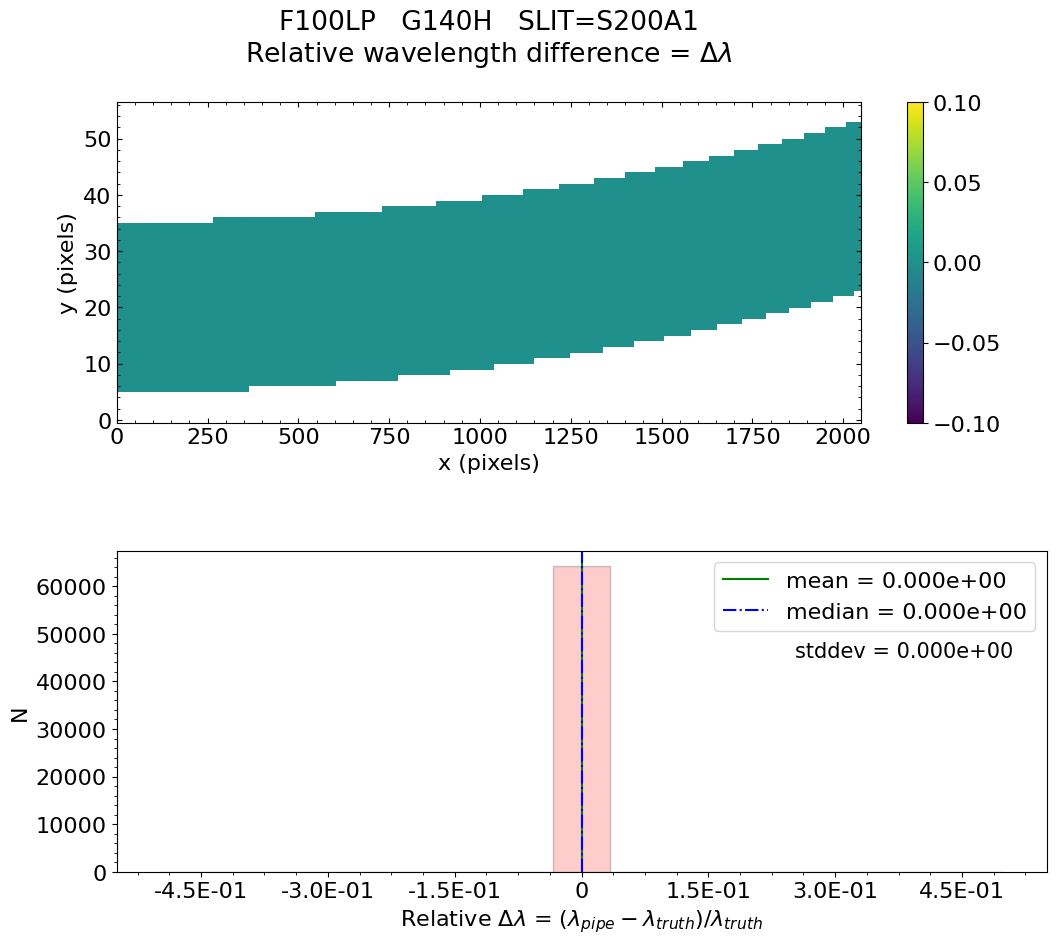

No output_directory was provided. Figures will NOT be saved.


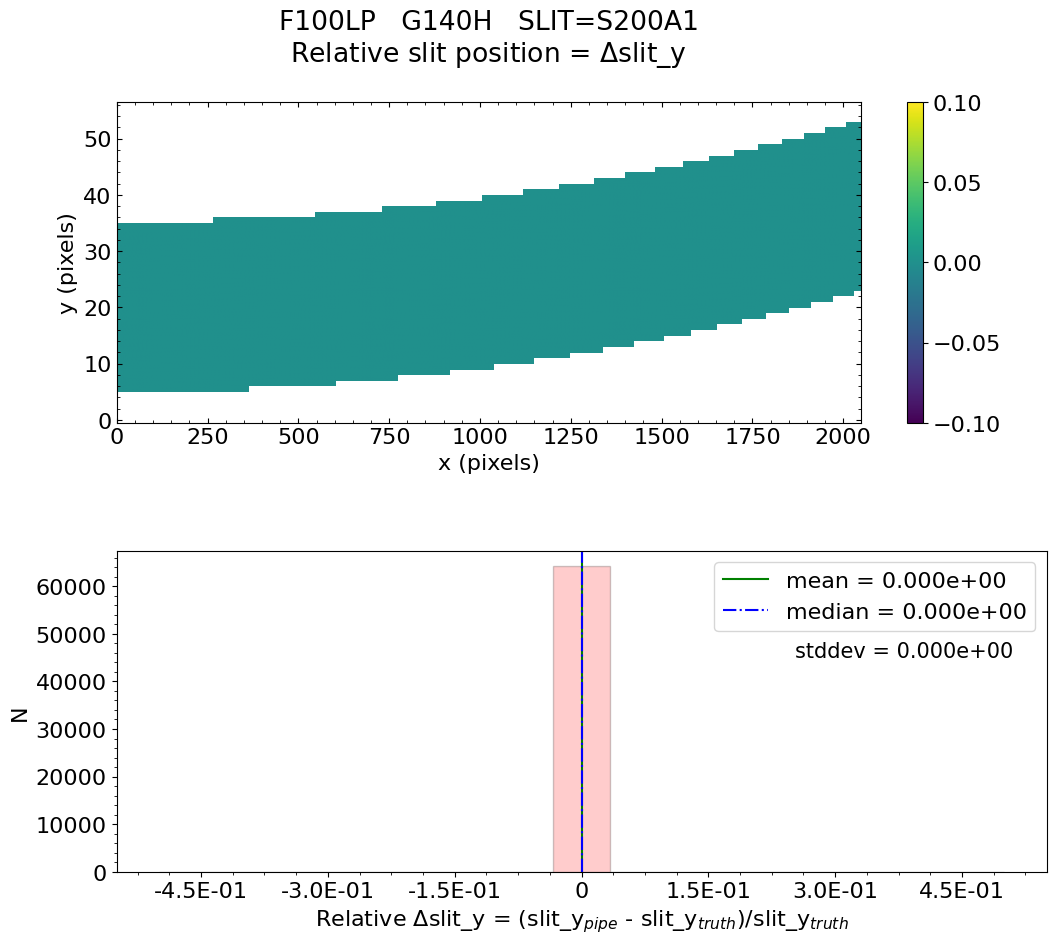

No output_directory was provided. Figures will NOT be saved.


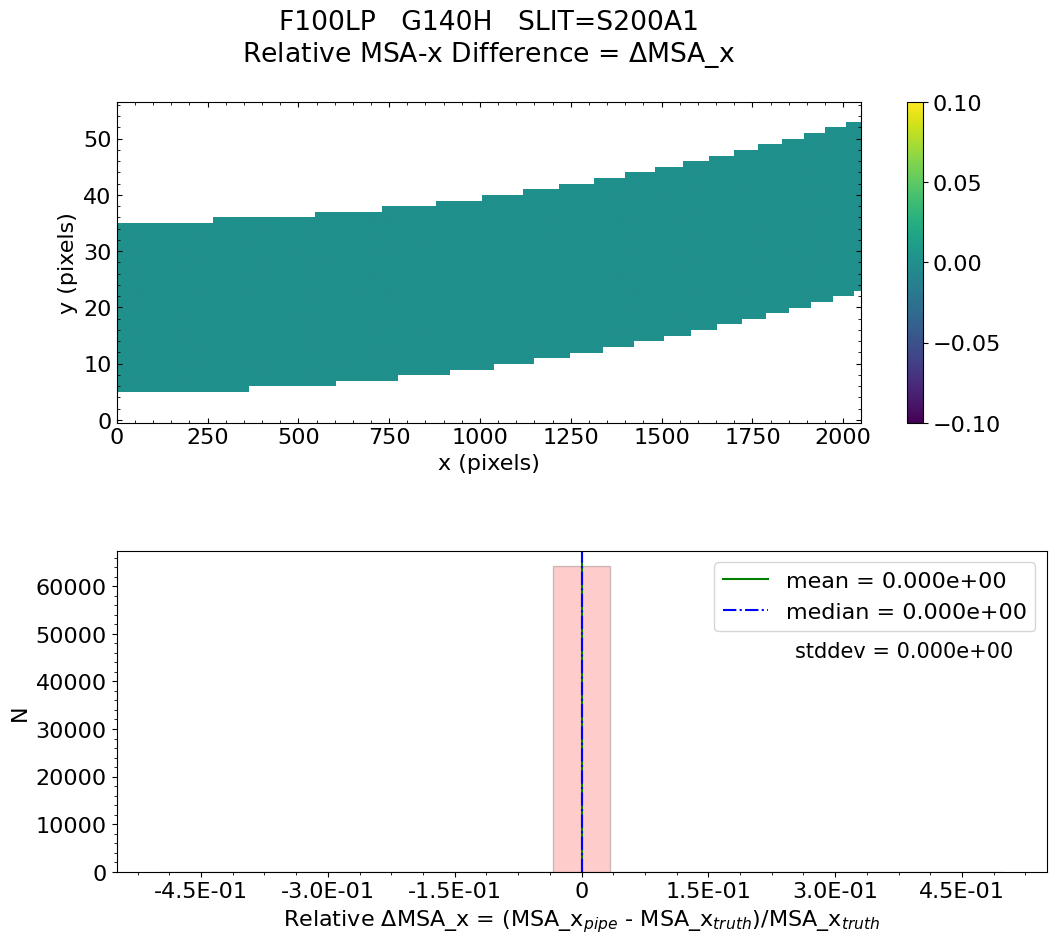

No output_directory was provided. Figures will NOT be saved.


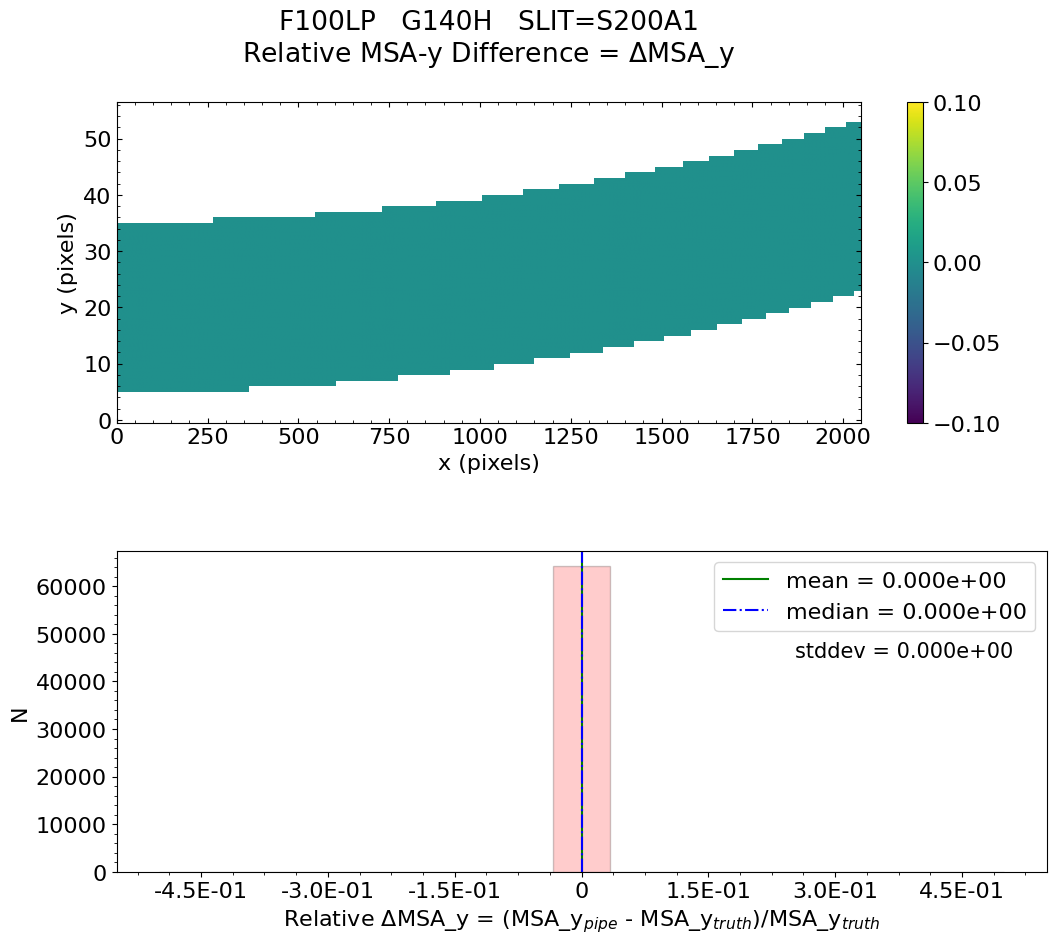

No output_directory was provided. Figures will NOT be saved.


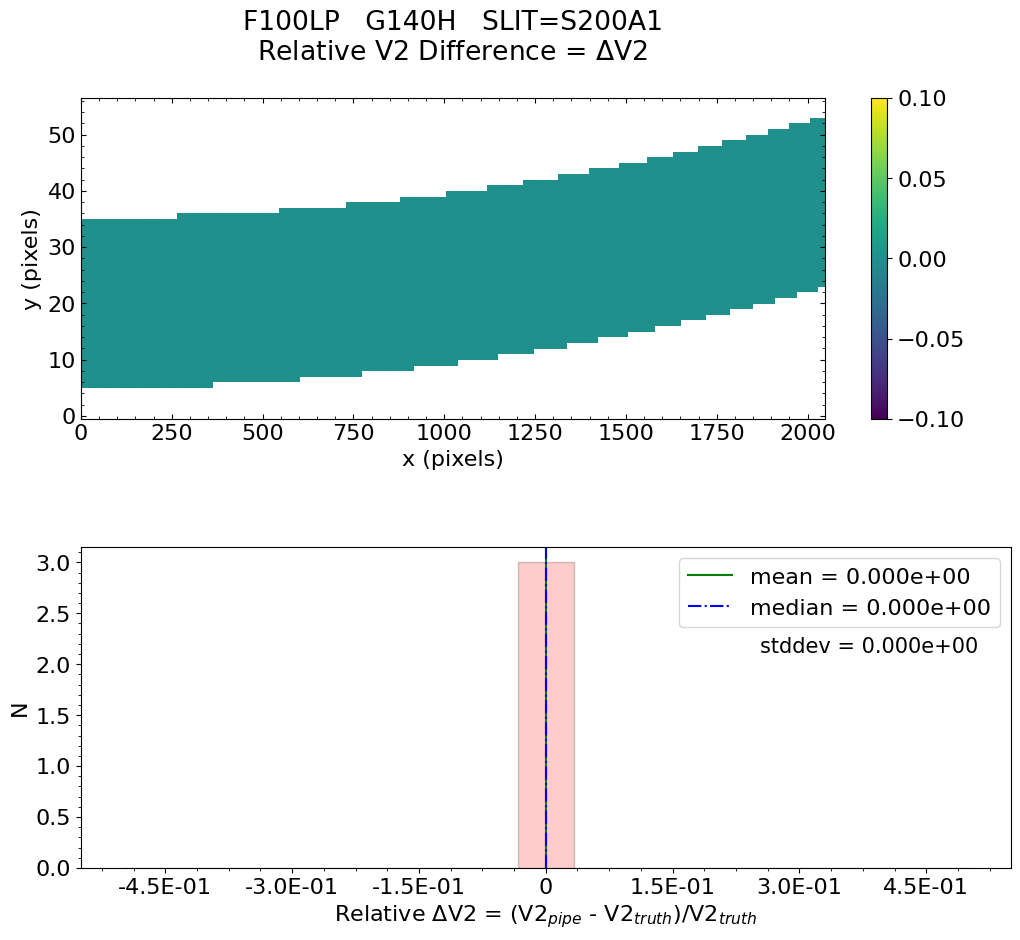

No output_directory was provided. Figures will NOT be saved.


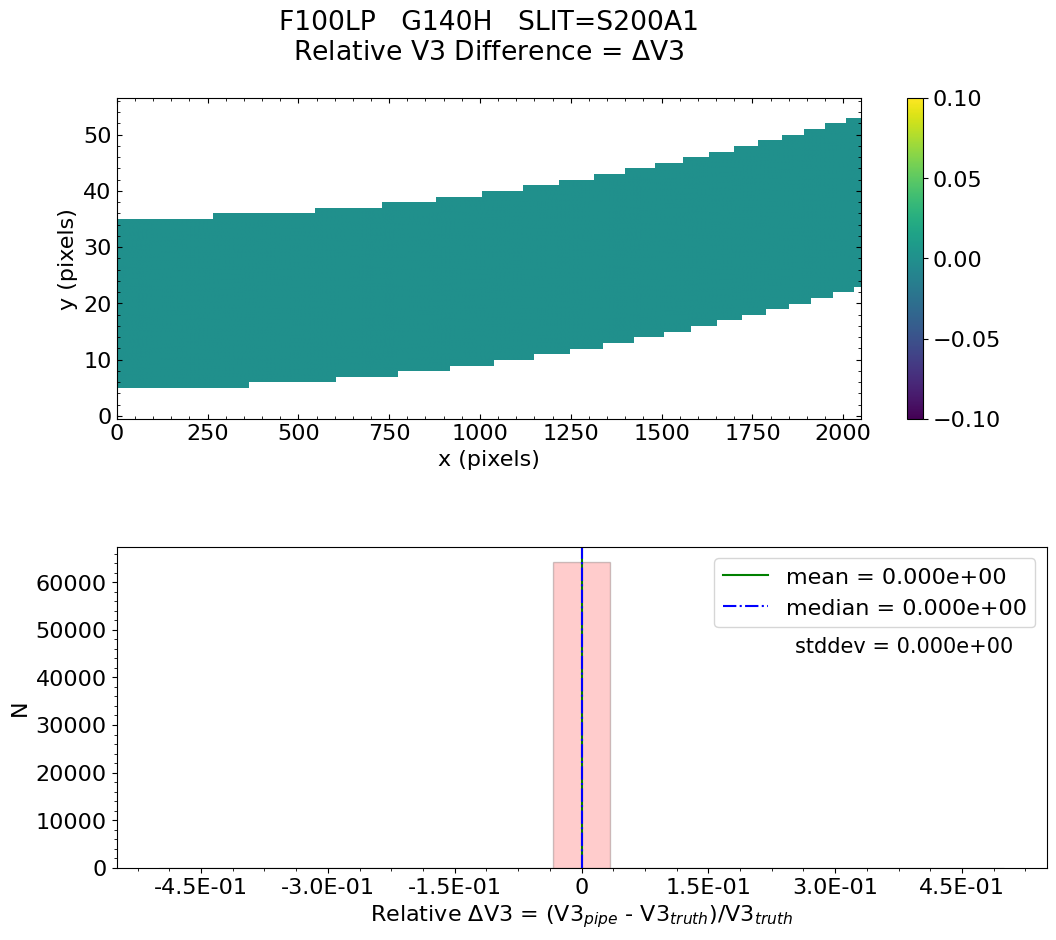


Working with slit: S200A2


Avalable frames:  ['detector', 'sca', 'gwa', 'slit_frame', 'msa_frame', 'oteip', 'v2v3', 'v2v3vacorr', 'world']

   Relative Wavelength Difference  :   mean = 2.223e-20    median = 0.000e+00    stdev = 3.158e-18
    Maximum   RelativeWavelength Difference = 3.050e-16
    Minimum   RelativeWavelength Difference = -1.502e-16
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  PASSED


   Relative Slit-Y Difference  :   mean = 2.360e-16    median = 0.000e+00    stdev = 1.399e-14
    Maximum   RelativeSlit-Y Difference = 4.357e-13
    Minimum   RelativeSlit-Y Difference = -1.105e-13
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
               


   Relative V2 difference  :   mean = -5.543e-19    median = 0.000e+00    stdev = 1.549e-17
    Maximum   RelativeV2 difference = 3.608e-16
    Minimum   RelativeV2 difference = -3.603e-16
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for V2 difference:  PASSED


   Relative V3 difference  :   mean = -3.153e-19    median = 0.000e+00    stdev = 1.203e-17
    Maximum   RelativeV3 difference = 2.322e-16
    Minimum   RelativeV3 difference = -2.320e-16
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for V3 difference:  PASSED

No output_directory was provided. Figures will be saved in current wor

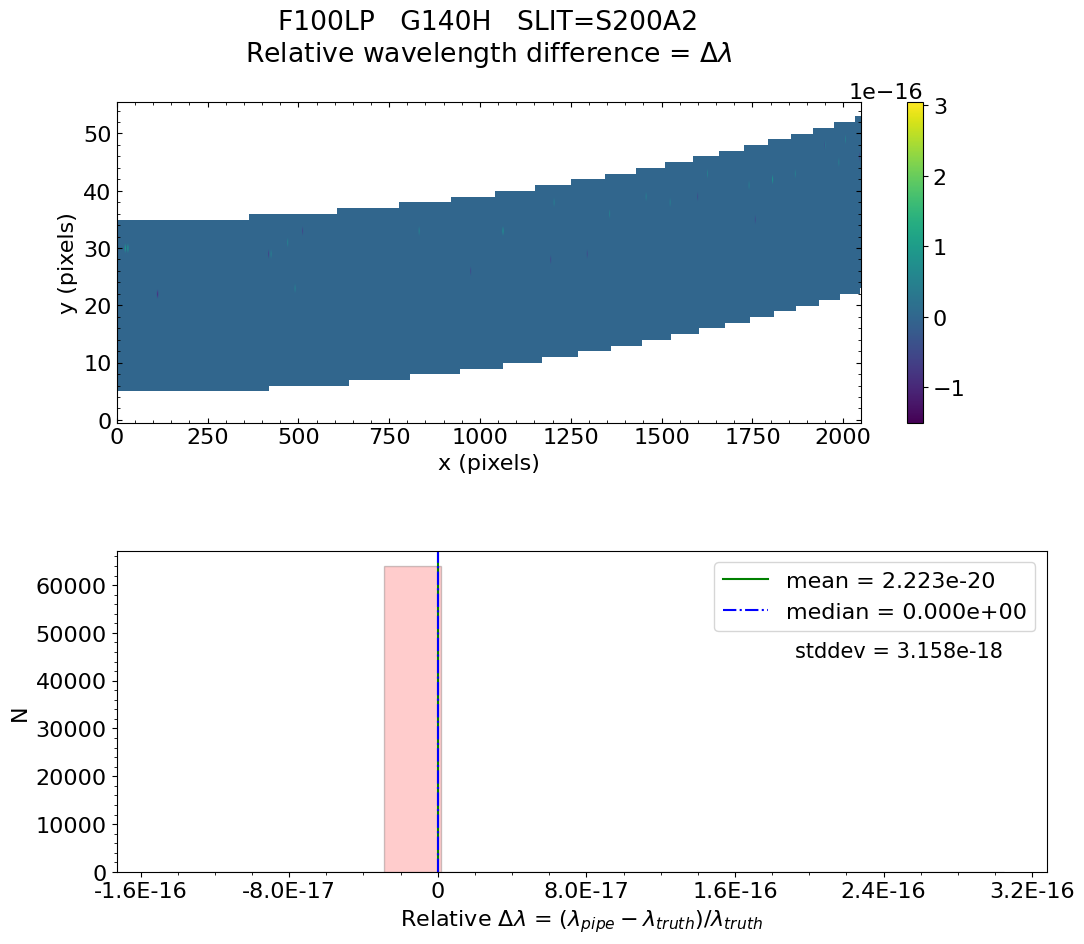

No output_directory was provided. Figures will NOT be saved.


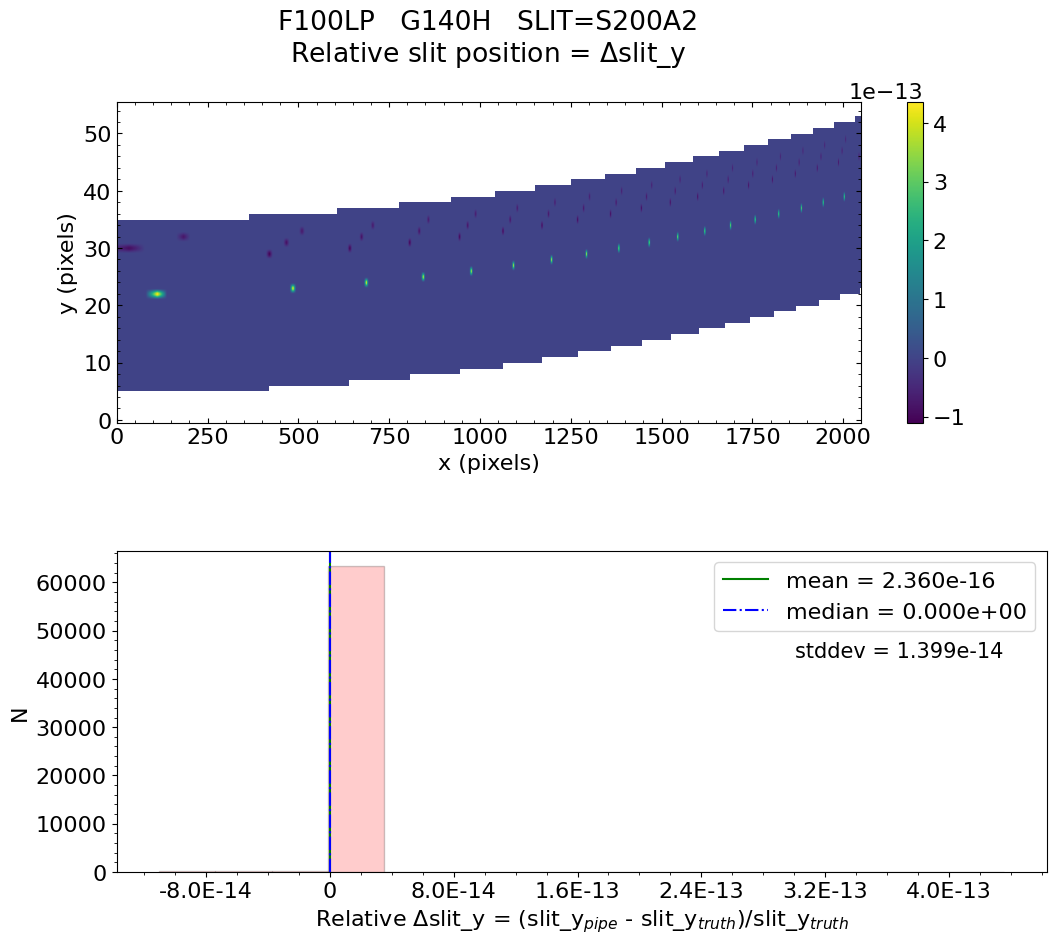

No output_directory was provided. Figures will NOT be saved.


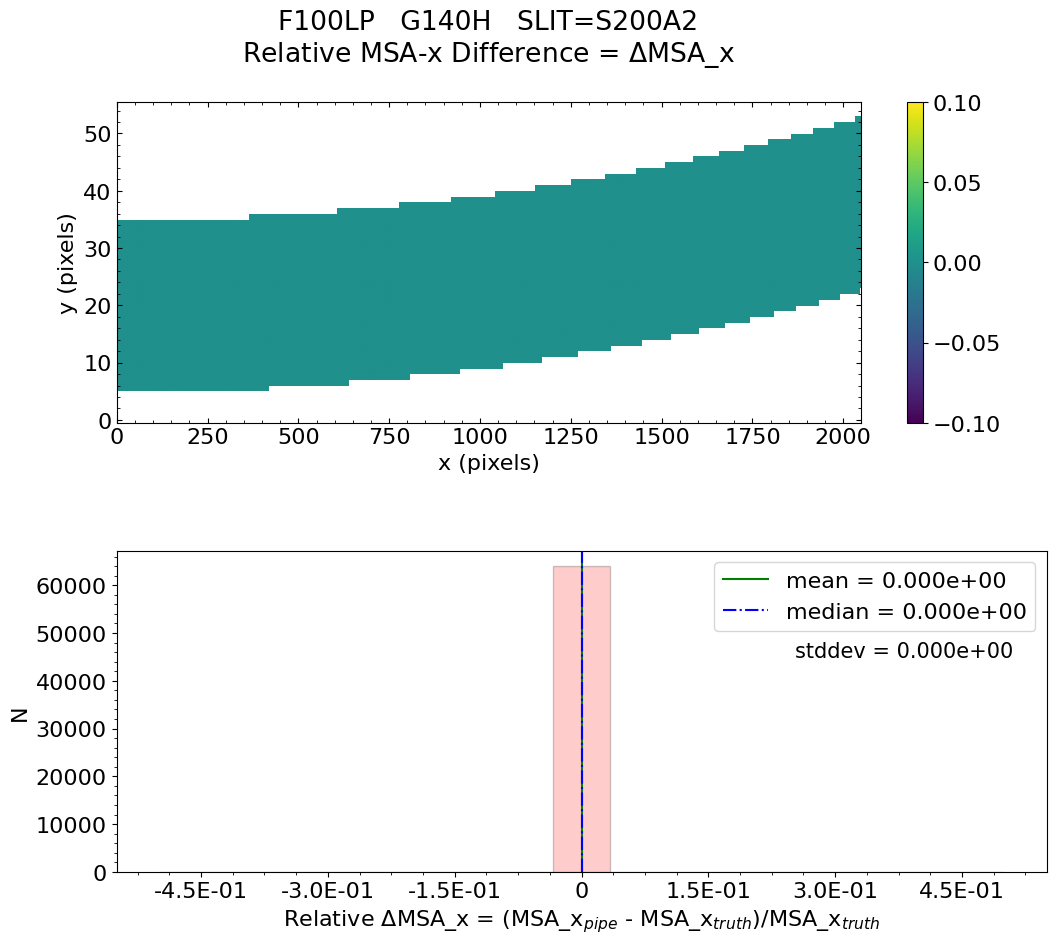

No output_directory was provided. Figures will NOT be saved.


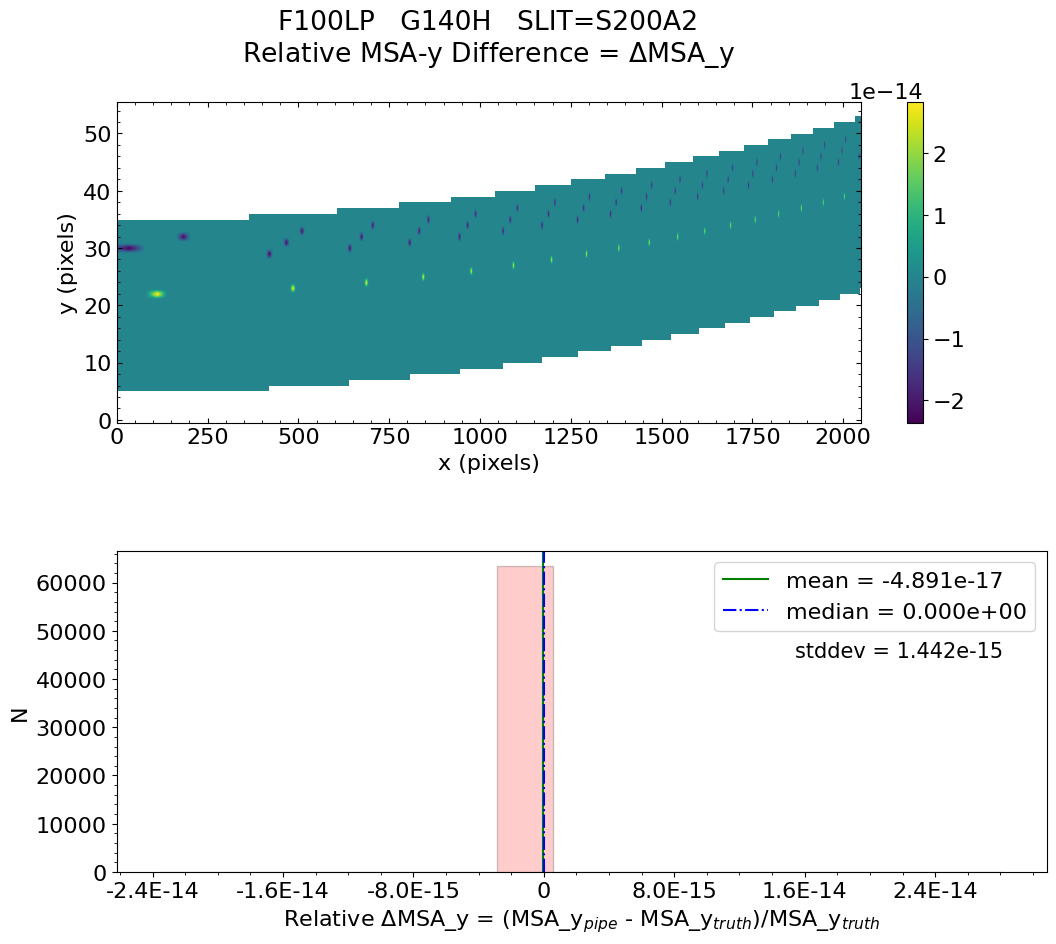

No output_directory was provided. Figures will NOT be saved.


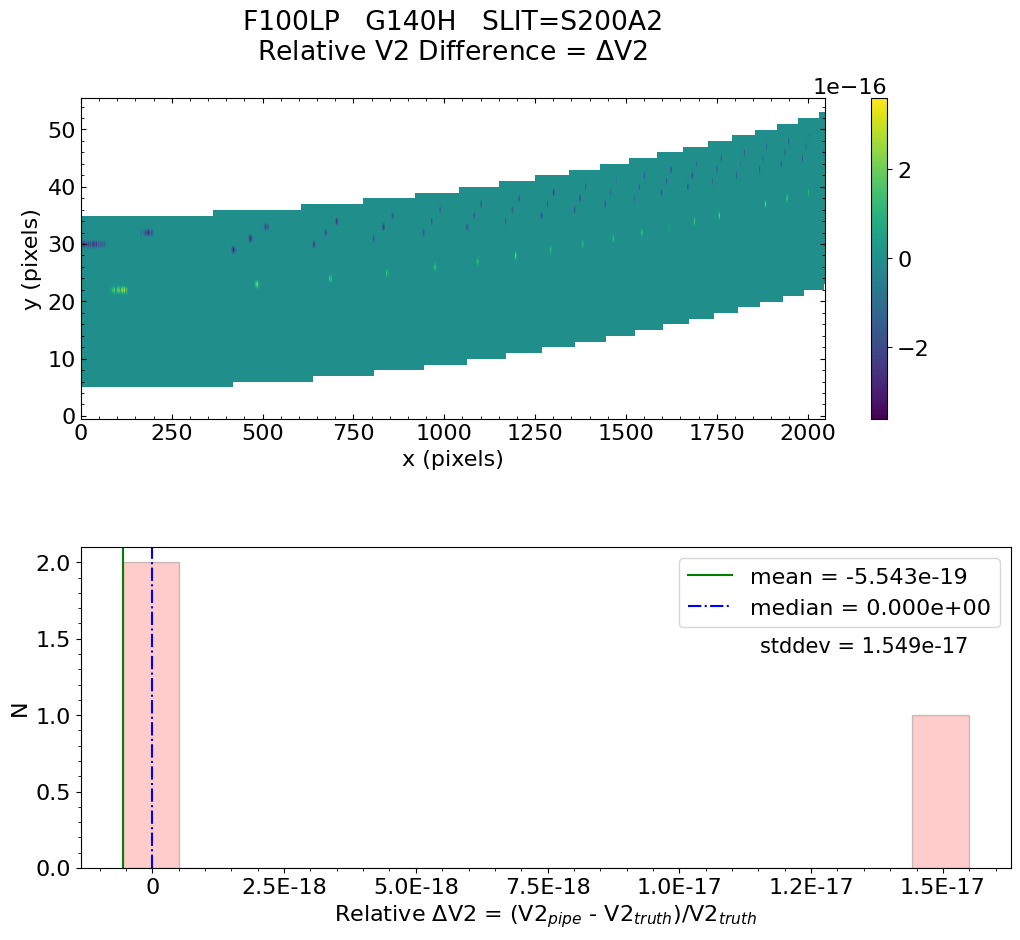

No output_directory was provided. Figures will NOT be saved.


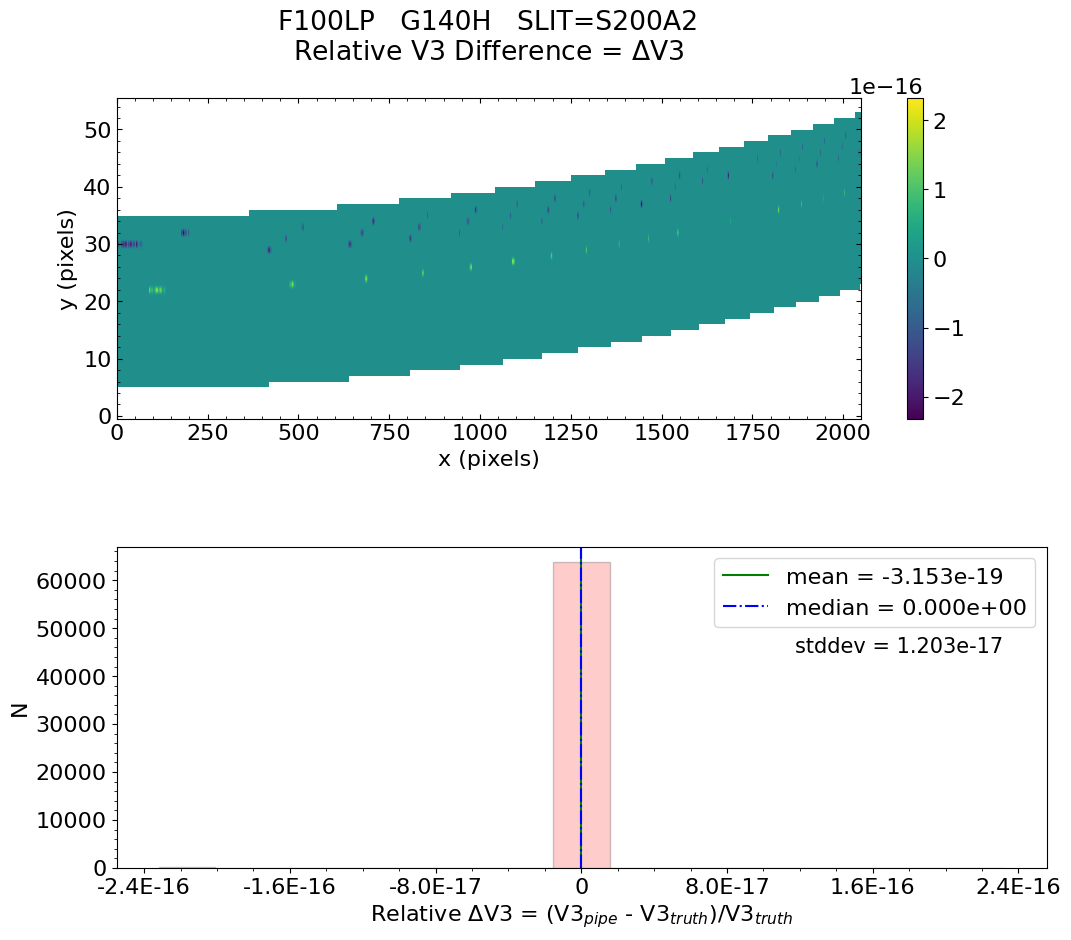


Working with slit: S400A1


Avalable frames:  ['detector', 'sca', 'gwa', 'slit_frame', 'msa_frame', 'oteip', 'v2v3', 'v2v3vacorr', 'world']

   Relative Wavelength Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeWavelength Difference = 0.000e+00
    Minimum   RelativeWavelength Difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  PASSED


   Relative Slit-Y Difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeSlit-Y Difference = -0.000e+00
    Minimum   RelativeSlit-Y Difference = -0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
               


   Relative V2 difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeV2 difference = 0.000e+00
    Minimum   RelativeV2 difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for V2 difference:  PASSED


   Relative V3 difference  :   mean = 0.000e+00    median = 0.000e+00    stdev = 0.000e+00
    Maximum   RelativeV3 difference = -0.000e+00
    Minimum   RelativeV3 difference = -0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for V3 difference:  PASSED

No output_directory was provided. Figures will be saved in current worki

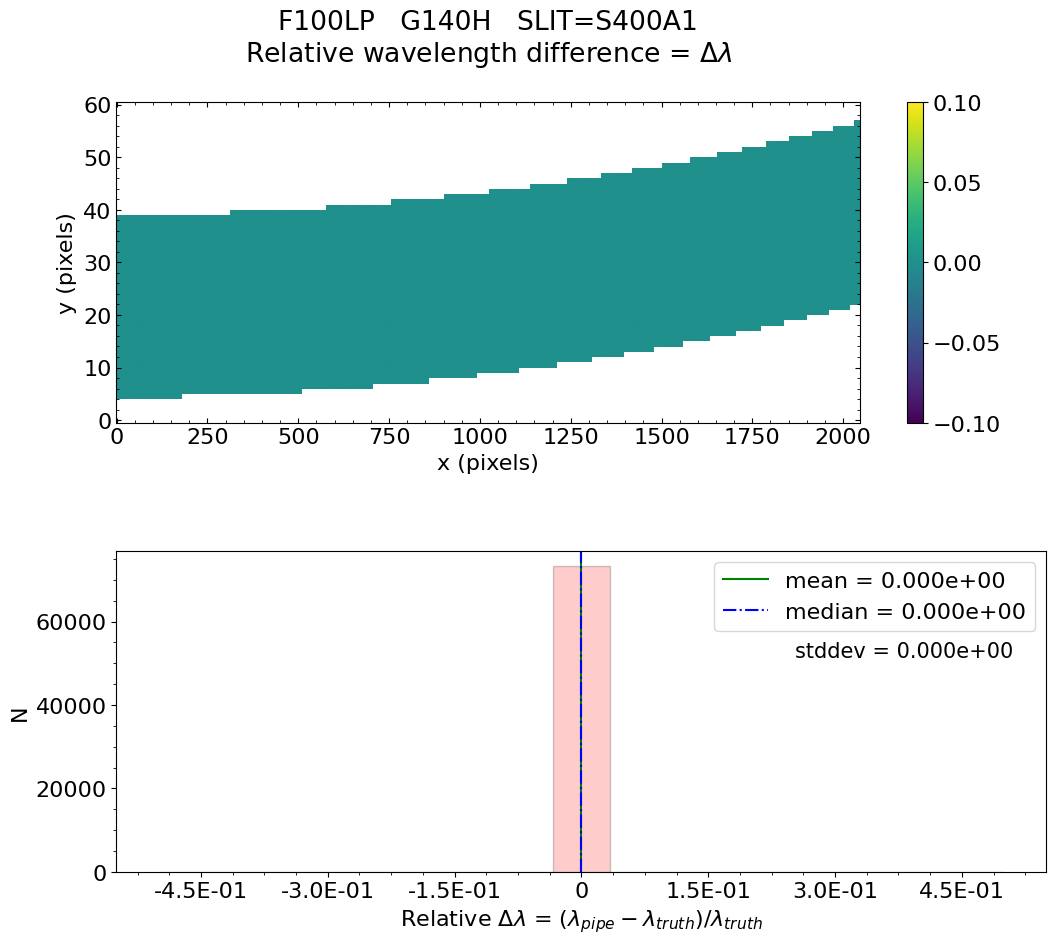

No output_directory was provided. Figures will NOT be saved.


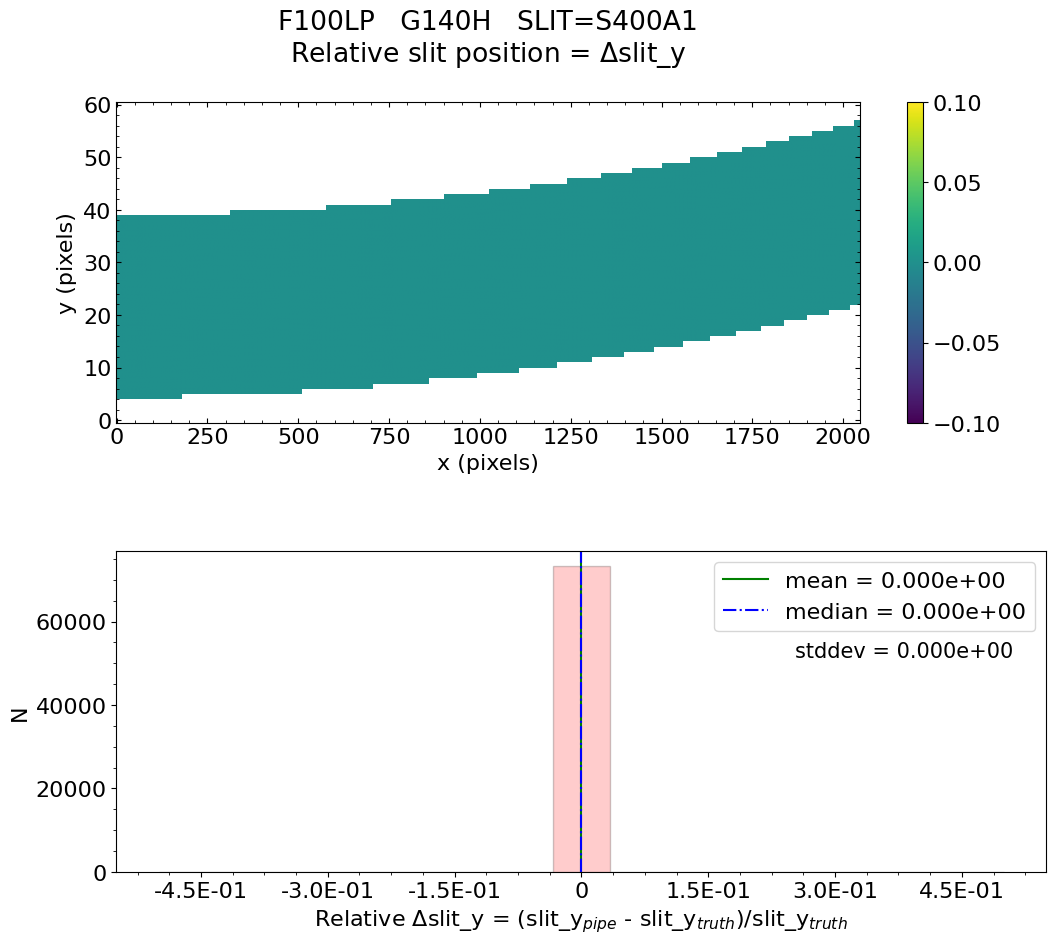

No output_directory was provided. Figures will NOT be saved.


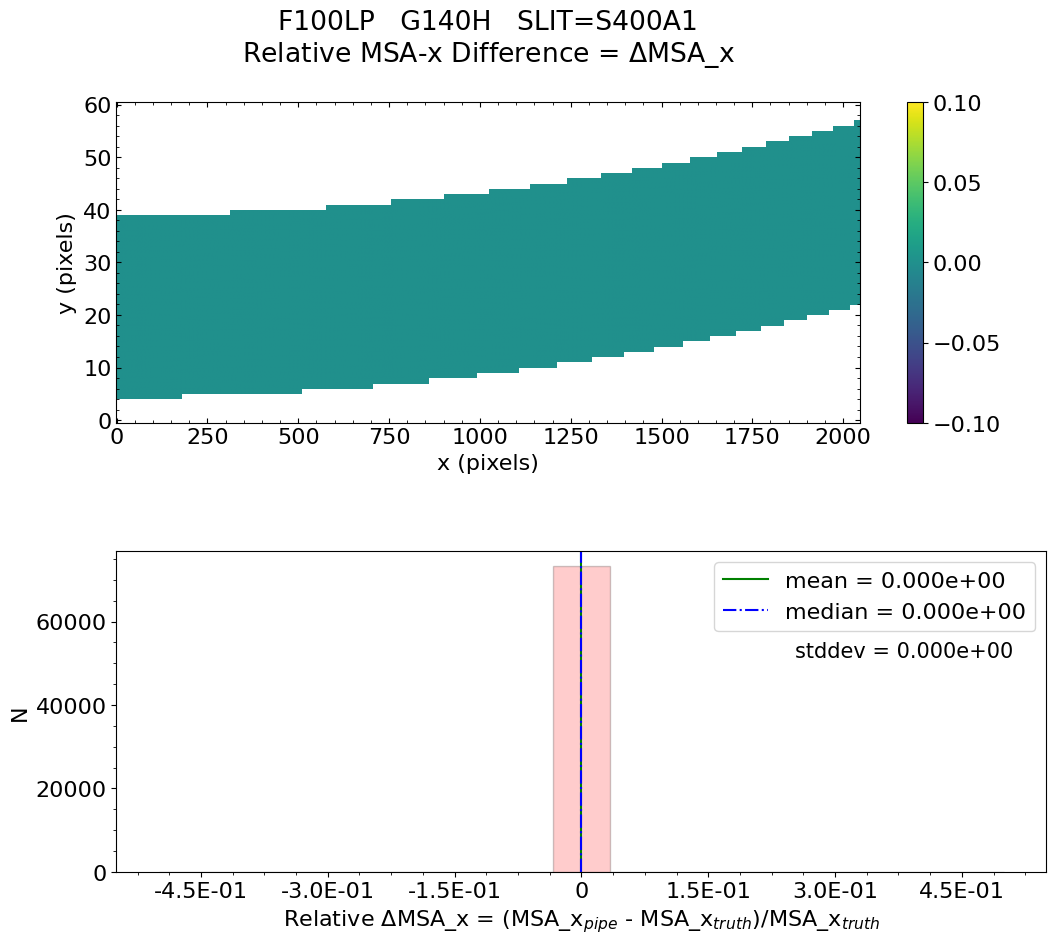

No output_directory was provided. Figures will NOT be saved.


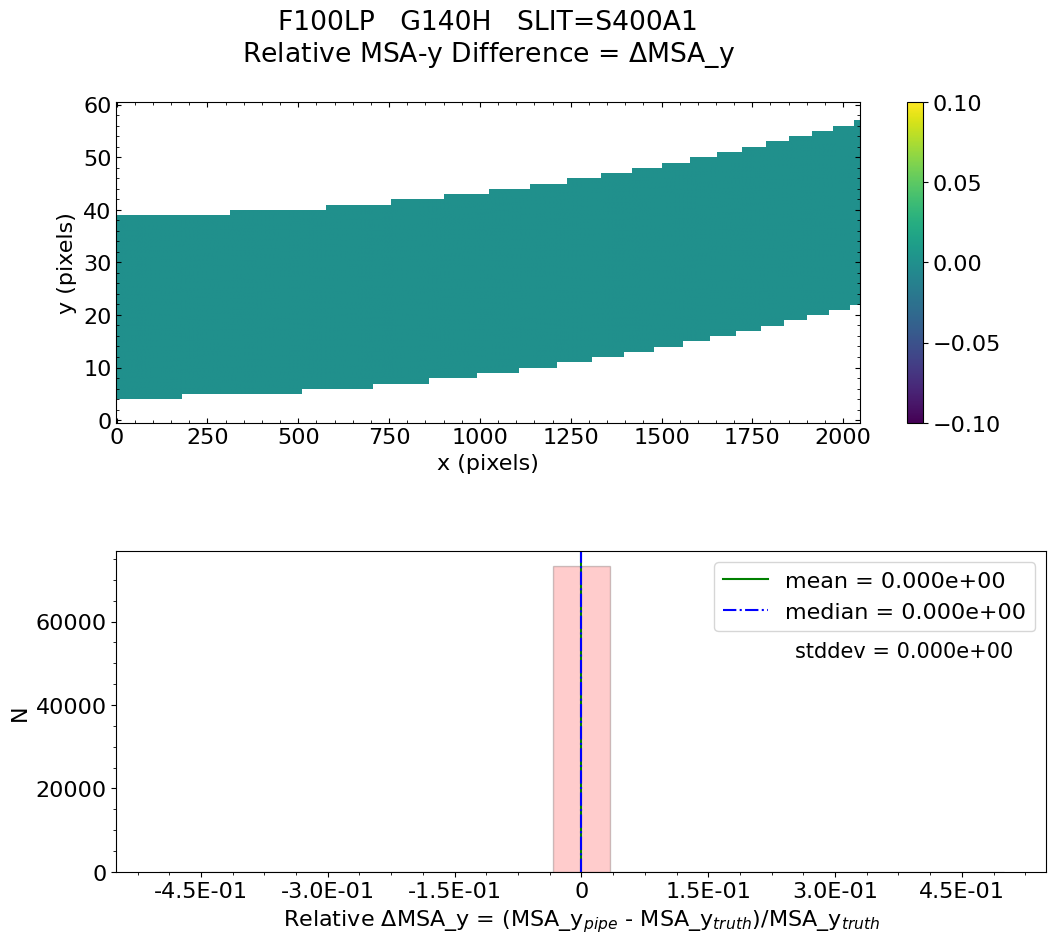

No output_directory was provided. Figures will NOT be saved.


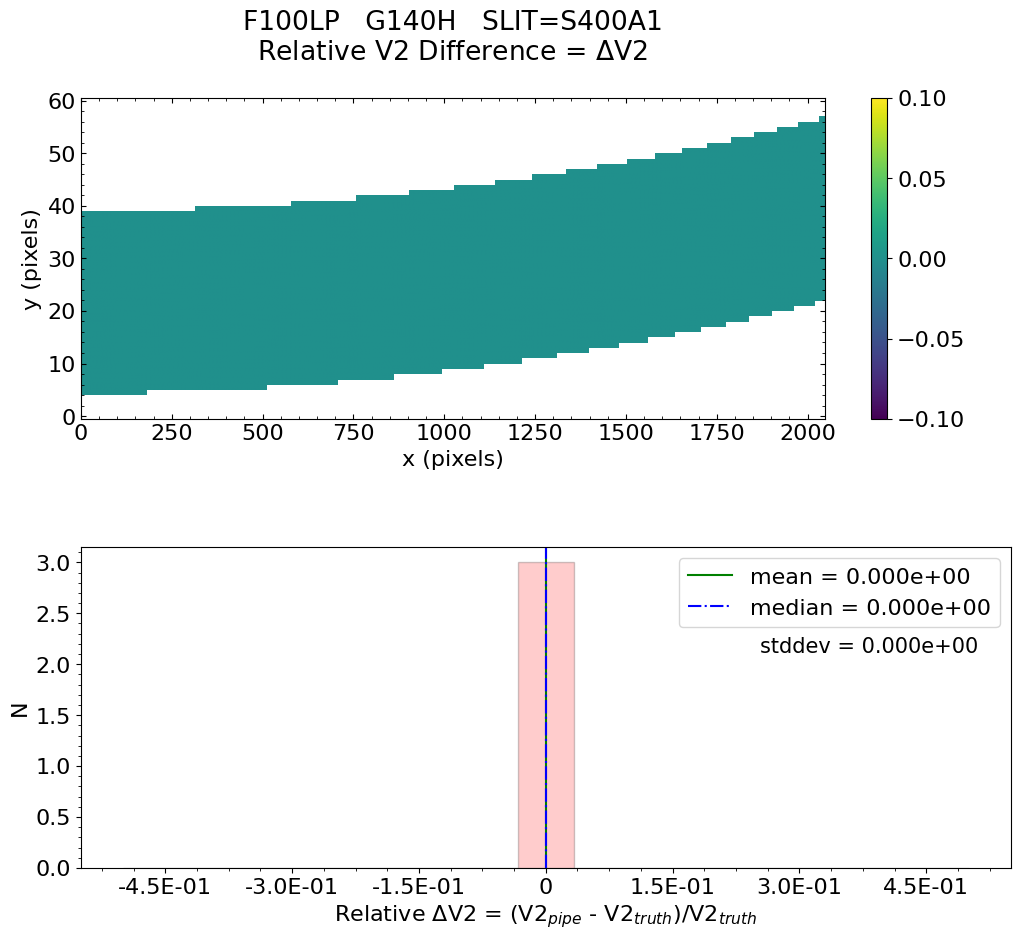

No output_directory was provided. Figures will NOT be saved.


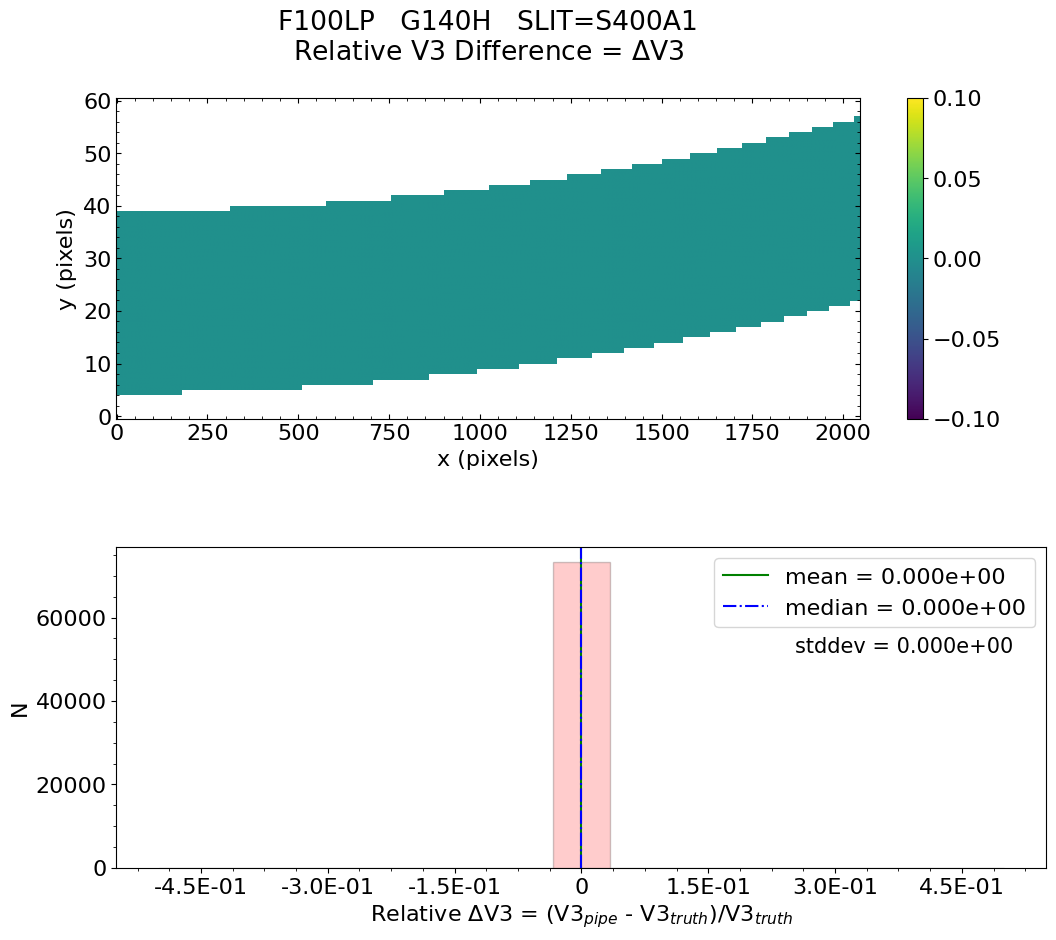


Working with slit: S1600A1


Avalable frames:  ['detector', 'sca', 'gwa', 'slit_frame', 'msa_frame', 'oteip', 'v2v3', 'v2v3vacorr', 'world']

   Relative Wavelength Difference  :   mean = 2.157e-20    median = 0.000e+00    stdev = 2.095e-18
    Maximum   RelativeWavelength Difference = 2.999e-16
    Minimum   RelativeWavelength Difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  PASSED


   Relative Slit-Y Difference  :   mean = -2.006e-16    median = 0.000e+00    stdev = 4.907e-15
    Maximum   RelativeSlit-Y Difference = -0.000e+00
    Minimum   RelativeSlit-Y Difference = -1.813e-13
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
              

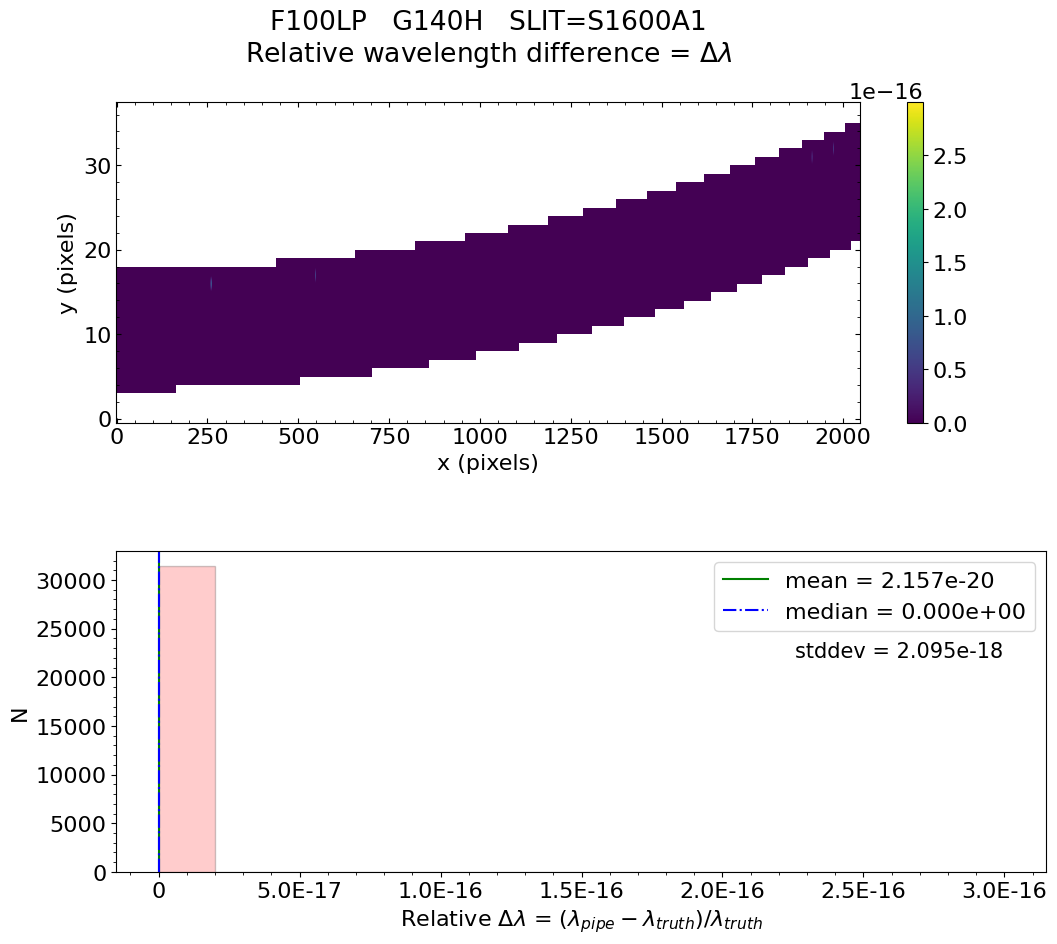

No output_directory was provided. Figures will NOT be saved.


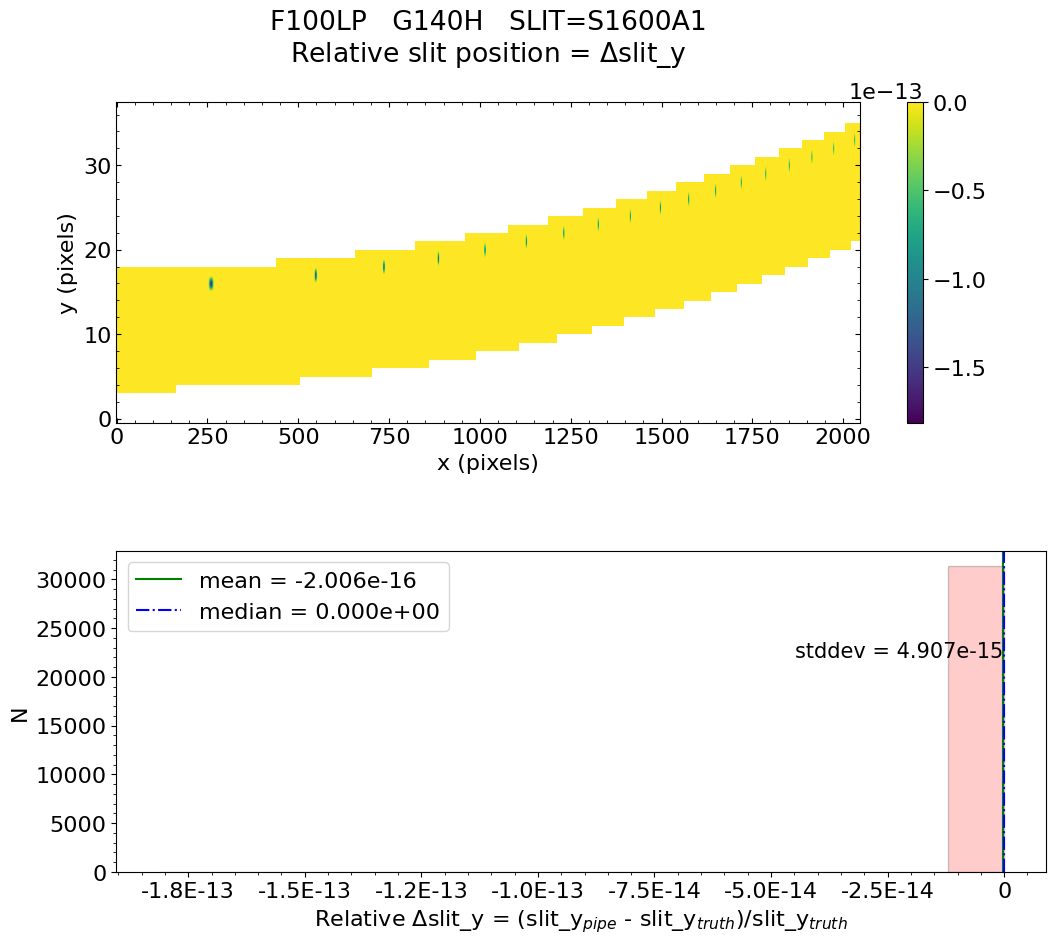

No output_directory was provided. Figures will NOT be saved.


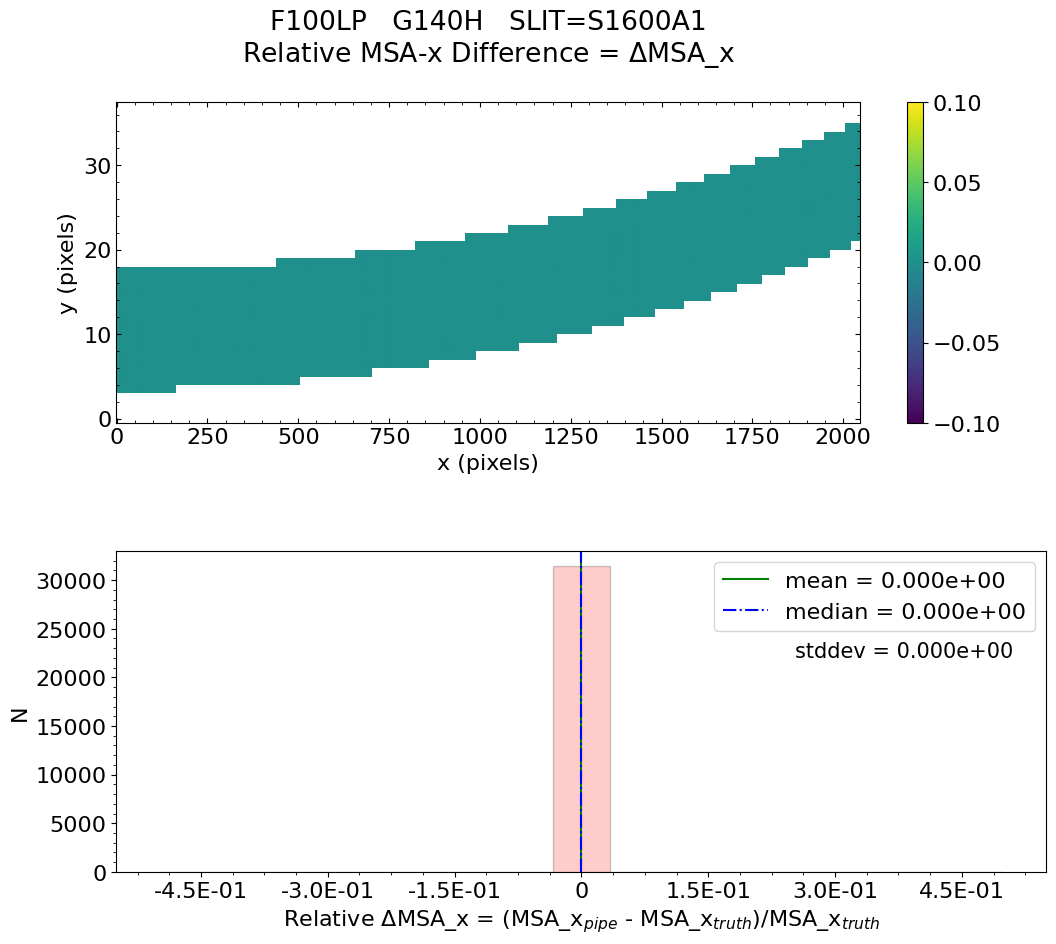

No output_directory was provided. Figures will NOT be saved.


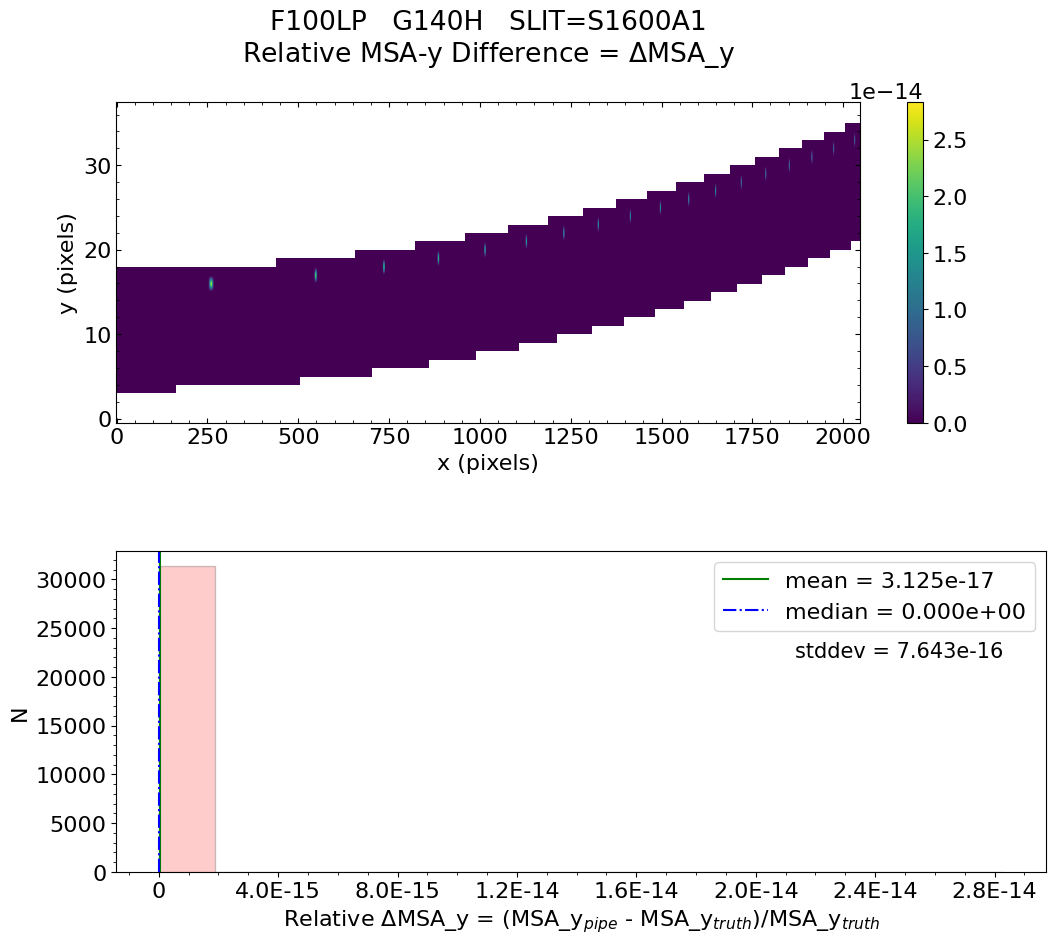

No output_directory was provided. Figures will NOT be saved.


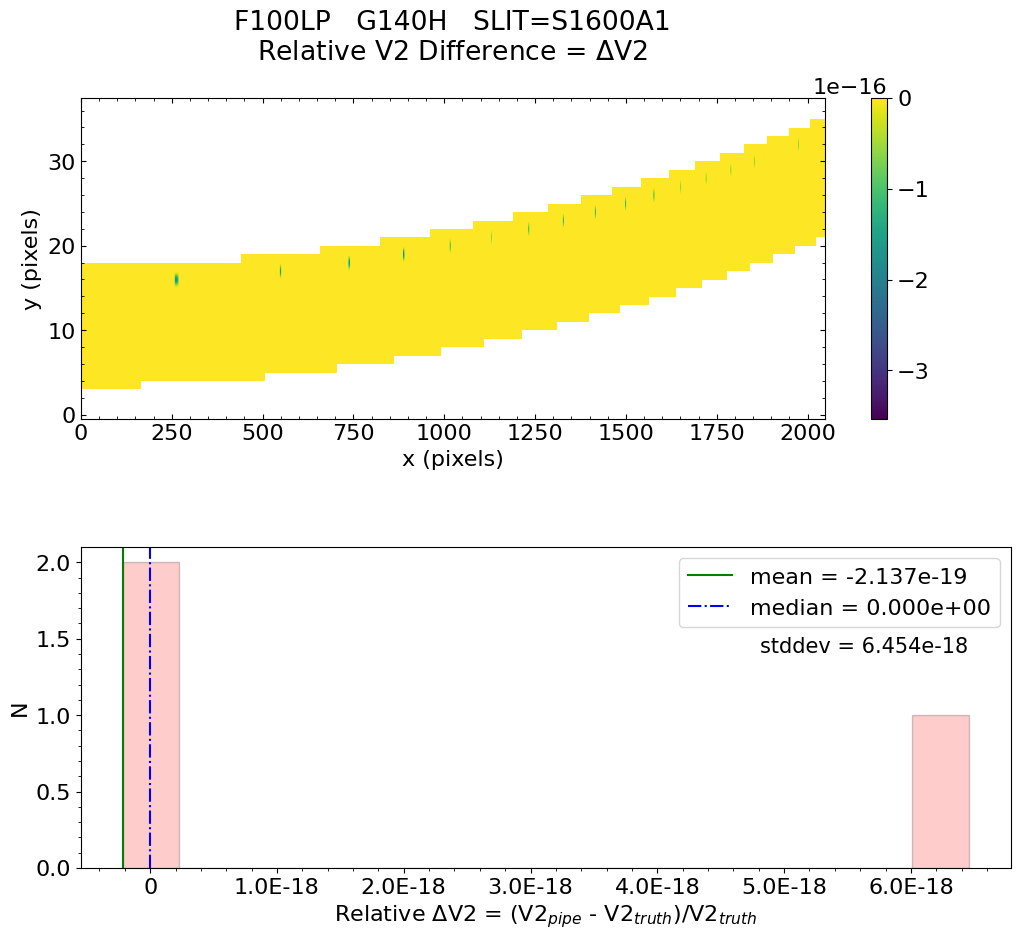

No output_directory was provided. Figures will NOT be saved.


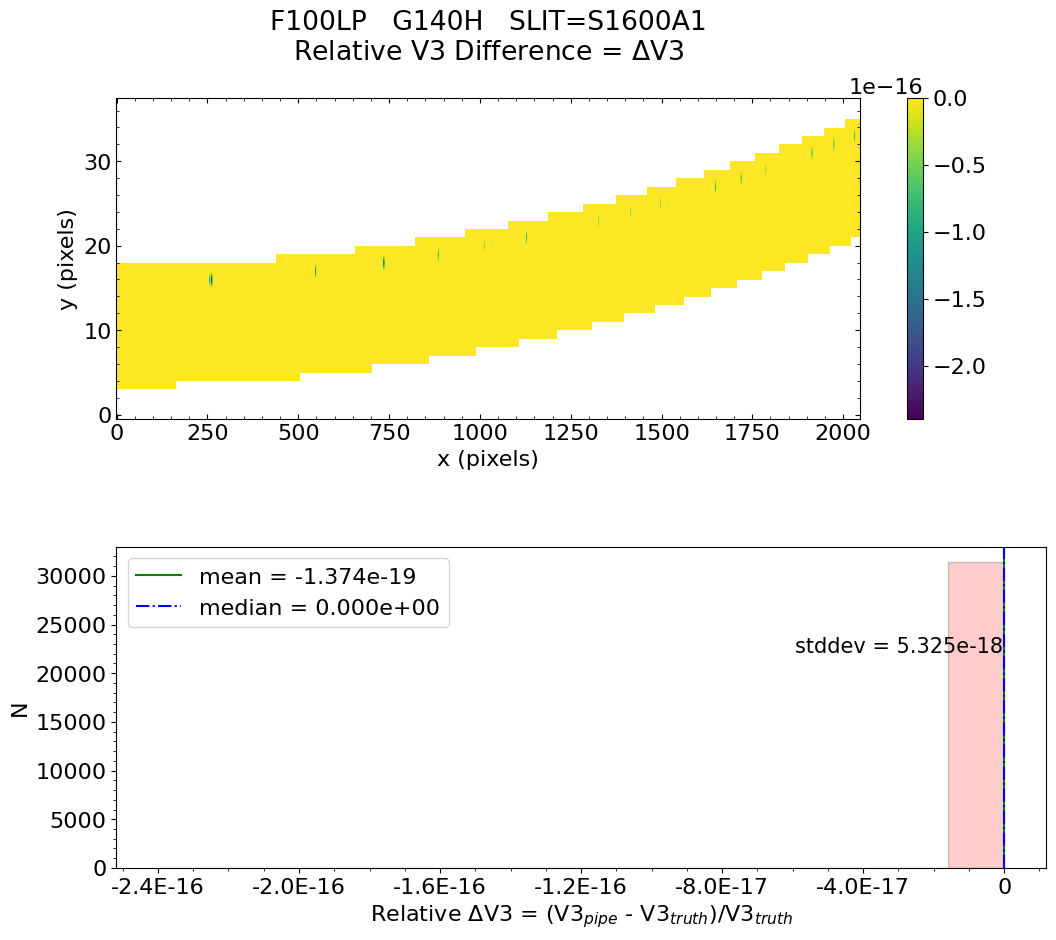


Working with slit: S200B1


Avalable frames:  ['detector', 'sca', 'gwa', 'slit_frame', 'msa_frame', 'oteip', 'v2v3', 'v2v3vacorr', 'world']

   Relative Wavelength Difference  :   mean = -5.903e-20    median = 0.000e+00    stdev = 3.821e-18
    Maximum   RelativeWavelength Difference = 2.133e-16
    Minimum   RelativeWavelength Difference = -2.973e-16
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

 * Result of the test for Wavelength Difference:  PASSED


   Relative Slit-Y Difference  :   mean = -1.500e-15    median = 0.000e+00    stdev = 3.476e-14
    Maximum   RelativeSlit-Y Difference = 1.400e-13
    Minimum   RelativeSlit-Y Difference = -1.091e-12
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
             


   Relative V2 difference  :   mean = 5.958e-19    median = 0.000e+00    stdev = 1.138e-17
    Maximum   RelativeV2 difference = 3.873e-16
    Minimum   RelativeV2 difference = 0.000e+00
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%

Converting pipeline results to degrees to compare with truth file

   Relative V2 difference  :   mean = -9.997e-01    median = -9.997e-01    stdev = 7.073e-17
    Maximum   RelativeV2 difference = -9.997e-01
    Minimum   RelativeV2 difference = -9.997e-01
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 100%
                            ->  3xtheshold = 100%
                            ->  5xtheshold = 100%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING

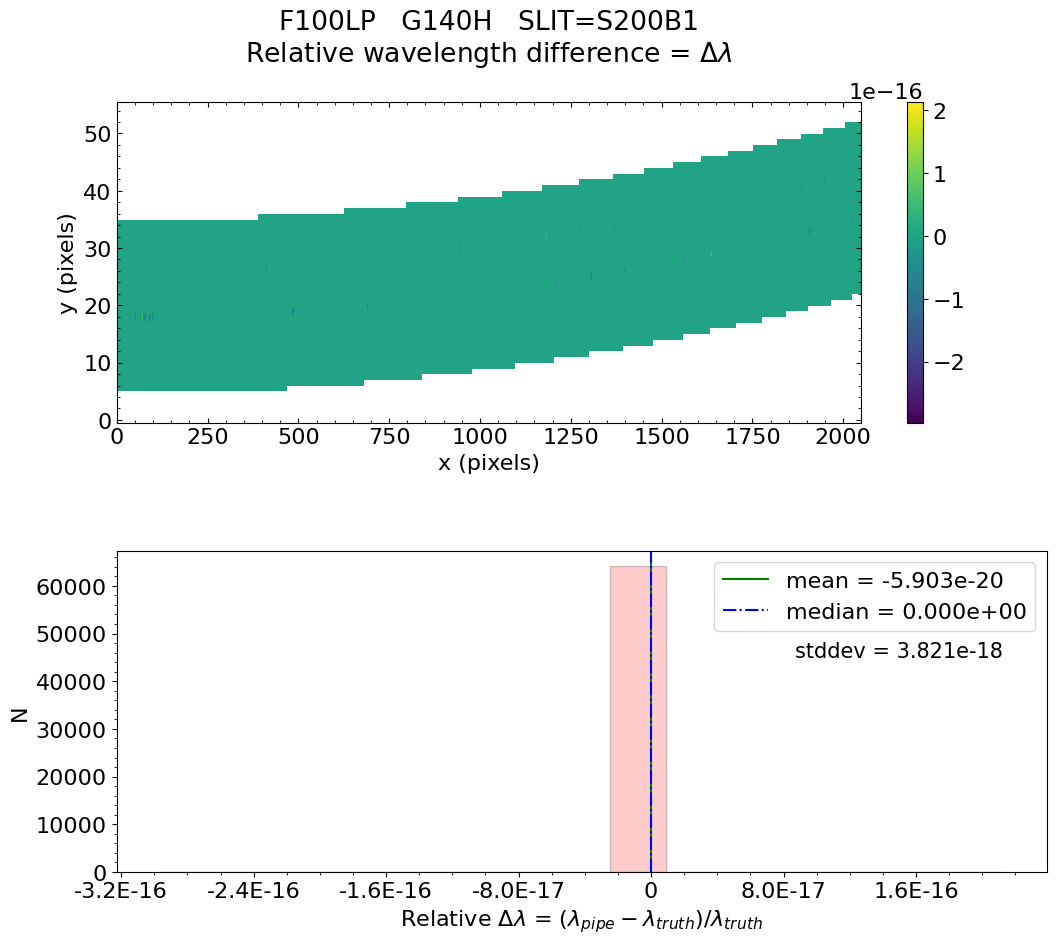

No output_directory was provided. Figures will NOT be saved.


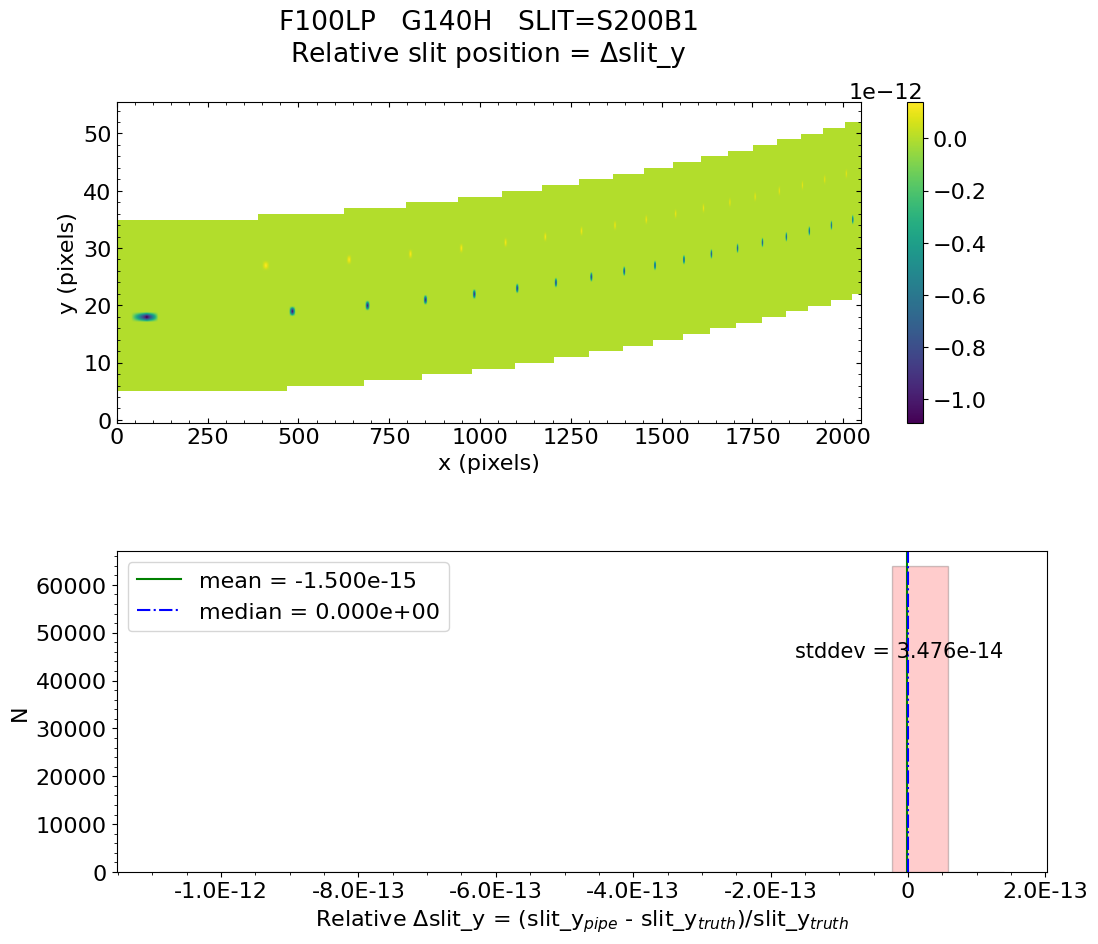

No output_directory was provided. Figures will NOT be saved.


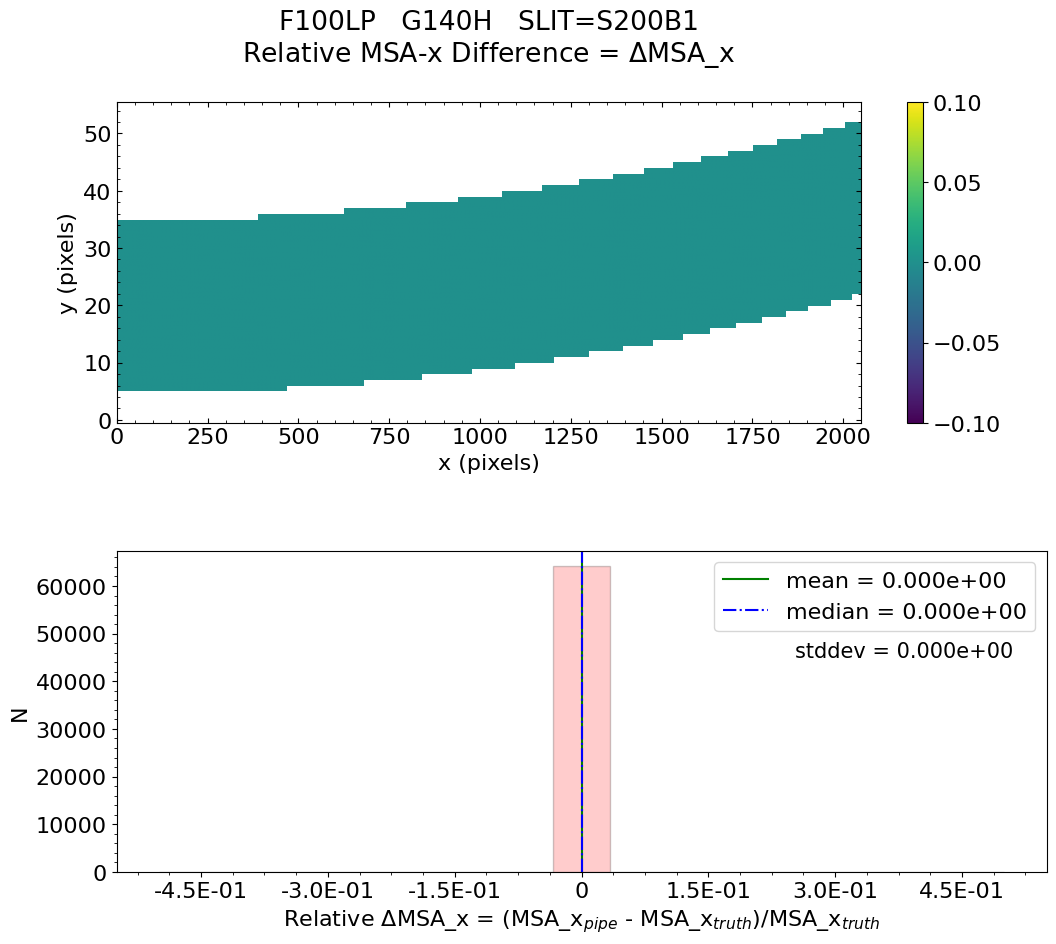

No output_directory was provided. Figures will NOT be saved.


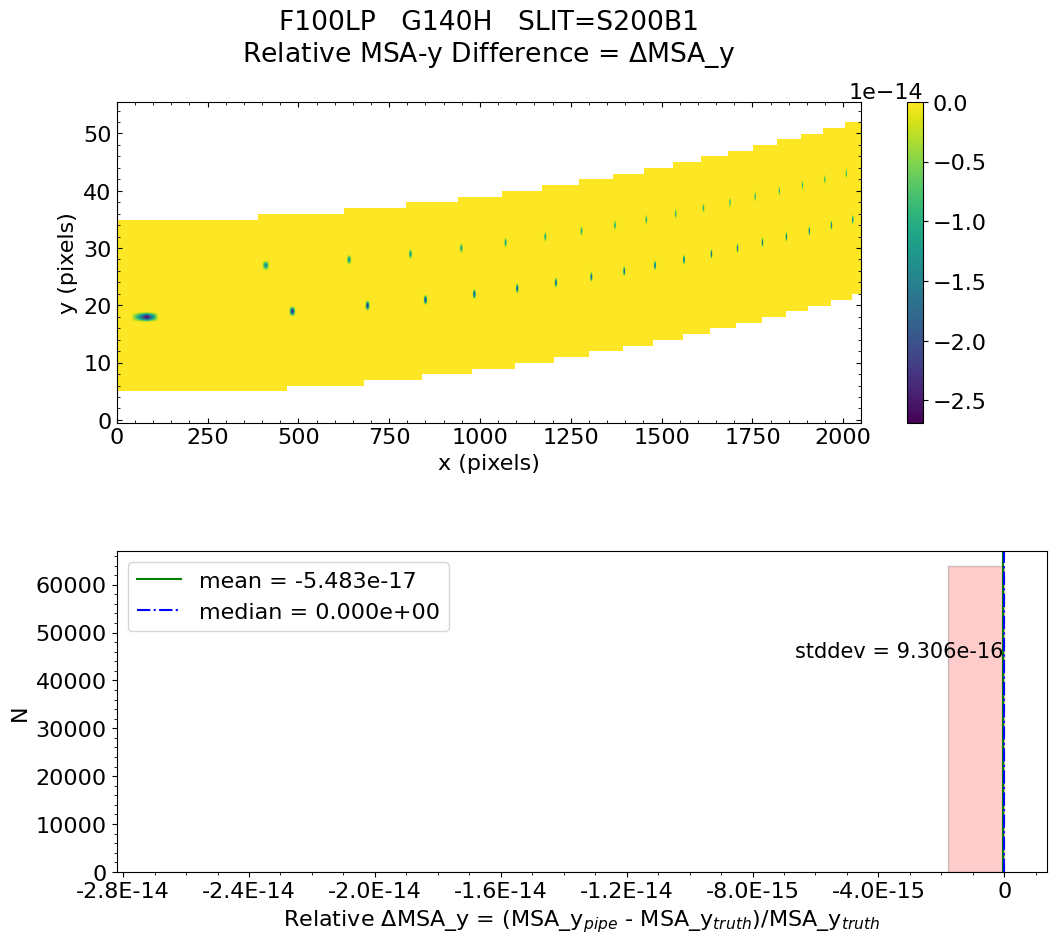

No output_directory was provided. Figures will NOT be saved.


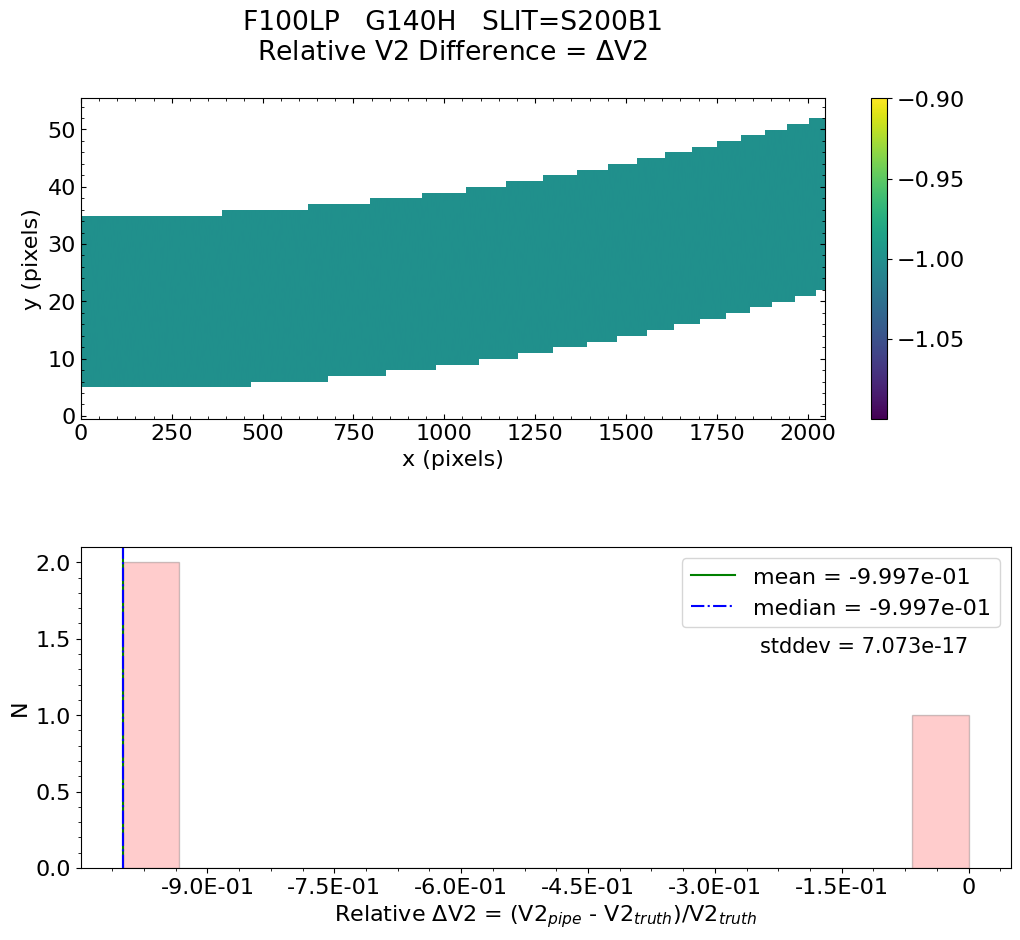

No output_directory was provided. Figures will NOT be saved.


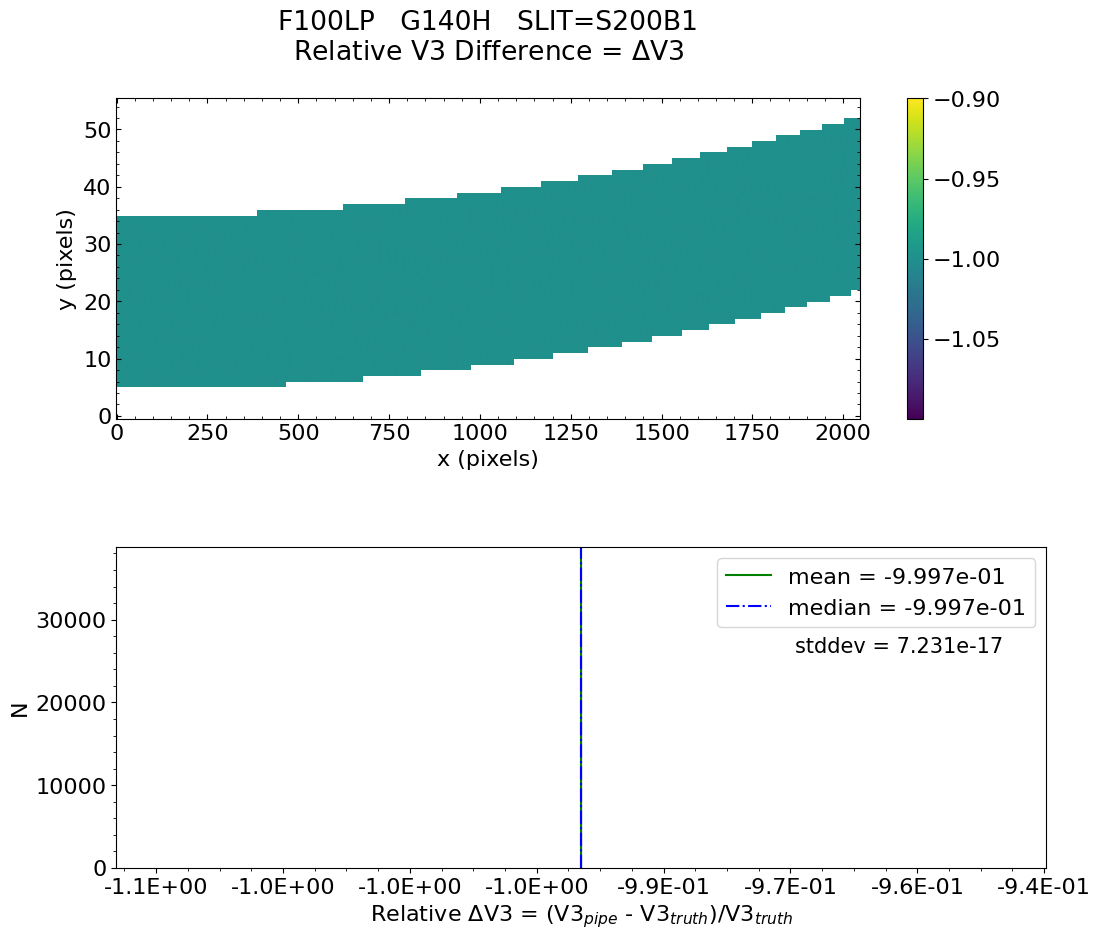


 * The test of V3 difference for slit S200A1 PASSED.

 * The test of V3 difference for slit S200A2 PASSED.

 * The test of V3 difference for slit S400A1 PASSED.

 * The test of V3 difference for slit S1600A1 PASSED.

 * The test of V3 difference for slit S200B1 FAILED.

 *** Final result for assign_wcs test will be reported as FAILED *** 

Did FS ALLSLITS assign_wcs validation test passed?  FAILED 




In [8]:
# Test the FS data for ALLSLITS
for mode_config, data_set_dict in testing_data.items():
    if 'allslits' not in mode_config:
        continue
        
    print('Fixed slit mode:  ', mode_config)
    for det in detectors:
        print('Testing files for detector: ', det)
        data = get_artifactory_file(data_set_dict, det)
        uncal_file, truth_file, msa_shutter_config = data
        uncal_basename = os.path.basename(uncal_file)
        print('Working with uncal_file: ', uncal_basename)
        
        # Make sure that there is an assign_wcs truth product to compare to, else skip this data set
        if truth_file is None:
            print('No truth file to compare to for this detector, skipping this data set.  \n')
            skip_file = True

        # Make sure these keywords are properly set
        filt = fits.getval(uncal_file, 'FILTER')
        if 'OPAQUE' in filt or 'allslits' in uncal_basename.lower():
            if 'clear' in uncal_basename.lower():
                filt = 'CLEAR'
            else:
                l = uncal_basename.split("_")
                for li in l:
                    if 'lp' in li:
                        filt = li.upper()
                        break
            fits.setval(uncal_file, 'FILTER', value=filt)
        print('Filter = ', filt)
        if 'bots' in uncal_basename.lower():
            fits.setval(uncal_file, 'TSOVISIT', value=True)
            fits.setval(uncal_file, 'FXD_SLIT', value='S1600A1')
        elif 'fs' in uncal_basename.lower():
            fits.setval(uncal_file, 'FXD_SLIT', value='S200A1')

        # Run the stage 1 pipeline 
        print('Running detector1 pipeline...')
        rate_object = Detector1Pipeline.call(uncal_file)
        
        # Run the stage 2 pipeline steps
        print('Running spec2 pipeline...')
        try:
            assign_wcs_object = AssignWcsStep.call(rate_object)
            skip_file = False
        except:
            print("No open slits fall on detector ", det)
            print("Skipping test for this file. \n")
            skip_file = True
            
        if not skip_file:  
            # Run the validation test
            %matplotlib inline
            print('Running test for FS...')
            result, _ = nptt.calwebb_spec2_pytests.auxiliary_code.compare_wcs_fs.compare_wcs(
                                                                            assign_wcs_object, 
                                                                            truth_file=truth_file, 
                                                                            esa_files_path=esa_files_path, 
                                                                            show_figs=show_figs,
                                                                            save_figs=save_figs, 
                                                                            threshold_diff=threshold_diff, 
                                                                            raw_data_root_file=raw_data_root_file,
                                                                            output_directory=None)     
        else:
            result = 'skipped'
        
        # Did the test passed 
        print("Did FS ALLSLITS assign_wcs validation test passed? ", result, "\n\n")
        rd = {uncal_basename: result}
        results_dict.update(rd)
        

In [9]:
# Summary of modes tested and their results 

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    if not isinstance(val, str):
        if val:
            val = 'PASSED'
        else:
            val = 'FAILED'
    print('{:<42} {:<8}'.format(key, val))


These are the final results of the tests: 
fs_allslits_g140h_f100lp_nrs1_uncal.fits   PASSED  
fs_allslits_g140h_f100lp_nrs2_uncal.fits   FAILED  


<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Sr. Science Software Engineer, NIRSpec
<br>**Updated On:** Sep/22/2022

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 